In [1]:
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.data.path.append('.')
import re
from collections import Counter
from heapq import nlargest
import copy
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SWASTIK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Dataset

In [2]:
with open("a.txt", "r",encoding="utf8") as f:
    data = f.read()
    
display(data[0:300])

'"The object of a translator should ever be to hold the mirror upto his author. That being so, his chief duty is to represent so far as practicable the manner in which his author\'s ideas have been expressed, retaining if possible at the sacrifice of idiom and taste all the peculiarities of his author'

### Refine Dataset

In [3]:
def split_to_sentences(data):
    sentences = nltk.tokenize.sent_tokenize(data)
    sentences = [s.strip() for s in sentences]
    sentences = [s.replace('"', '')  for s in sentences]
    sentences = [s.replace("'", "")  for s in sentences]
    sentences = [s.replace("Next: Section", "")  for s in sentences]
    sentences = [s.splitlines()[1] if len(s.splitlines())>1 else s.splitlines()[0] for s in sentences]
    sentences = [re.sub(r"\([^()]*\)", "", s)  for s in sentences]
    sentences = [s.replace("  ", "")  for s in sentences]
    sentences = [s for s in sentences if len(s.split()) > 2]
    return sentences  

In [4]:
data_length = len(split_to_sentences(data))

In [5]:
count_threshold = 1

### Tokenize Sentences

In [6]:
def tokenize_sentences(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        
        sentence = sentence.lower()
        tokenized =nltk.word_tokenize(sentence)
        tokenized_sentences.append(tokenized)
    
    return tokenized_sentences

In [8]:
def get_tokenized_data(data):
    sentences = split_to_sentences(data)
    tokenized_sentences = tokenize_sentences(sentences)
    return tokenized_sentences

### Create Train and Test Set

In [10]:
train_size = int(len(data) * 0.95)
train_data = get_tokenized_data(data[0:train_size])
test_data = split_to_sentences(data[train_size:])
print("data size = ",data_length)
print("train_data size = ",len(train_data))
print("test_data size= ",len(test_data))



data size =  97914
train_data size =  92545
test_data size=  5370


### Obtain frequency count of words

In [14]:
def count_words(tokenized_sentences):
    word_counts = {}
    for sentence in tokenized_sentences:
        for token in sentence:
            if token not in word_counts.keys():
                word_counts[token] = 1
            else:
                word_counts[token] += 1
    return word_counts

In [16]:
def get_words_with_nplus_frequency(tokenized_sentences, count_threshold):
    closed_vocab = []
    word_counts = count_words(tokenized_sentences)
    for word, cnt in word_counts.items():
        if cnt>=count_threshold:
            closed_vocab.append(word)
    return closed_vocab

### Replale out of vocabulary words with \<unk>

In [18]:
def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
    vocabulary = set(vocabulary)
    replaced_tokenized_sentences = []

    for sentence in tokenized_sentences:
        replaced_sentence = []
        for token in sentence:
            if token in vocabulary:
                replaced_sentence.append(token)
            else:
                replaced_sentence.append(unknown_token)

        replaced_tokenized_sentences.append(replaced_sentence)
        
    return replaced_tokenized_sentences

In [20]:
def preprocess_data(train_data, test_data, count_threshold):
    vocabulary = get_words_with_nplus_frequency(train_data, count_threshold)
    
    train_data_replaced = replace_oov_words_by_unk(train_data, vocabulary, unknown_token="<unk>")

    test_data_replaced = replace_oov_words_by_unk(test_data, vocabulary, unknown_token="<unk>")
    
    return train_data_replaced, test_data_replaced, vocabulary

### Obtain Processed Data

In [21]:
minimum_freq = count_threshold
train_data_processed, test_data_processed, vocabulary = preprocess_data(train_data, 
                                                                        test_data, 
                                                                        minimum_freq)

### Create Count and Probability Matrix

In [23]:
def count_n_grams(data, n, start_token='<s>', end_token = '<e>'):
    n_grams = {}
    for sentence in data:
        sentence = [start_token]*(n)+sentence+[end_token]
        sentence = tuple(sentence)
        for i in range(len(sentence)-n+1):
            n_gram = sentence[i:i+n]

            if n_gram in n_grams.keys():
                n_grams[n_gram] += 1
            else:
                n_grams[n_gram] = 1
    return n_grams

In [25]:
def estimate_probability(word, previous_n_gram, 
                         n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):

    previous_n_gram = tuple(previous_n_gram)

    previous_n_gram_count = n_gram_counts.get(previous_n_gram,0)


    denominator = previous_n_gram_count+k*vocabulary_size
    
    n_plus1_gram = list(previous_n_gram)
    n_plus1_gram.append(word)
    n_plus1_gram = tuple(n_plus1_gram)
    
    n_plus1_gram_count = n_plus1_gram_counts.get(n_plus1_gram,0)
        
    numerator = n_plus1_gram_count+k
    
    probability = numerator/denominator
    
    return probability

In [28]:
def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0):
    previous_n_gram = tuple(previous_n_gram)
    vocabulary = vocabulary + ["<e>", "<unk>"]
    vocabulary_size = len(vocabulary)
    
    probabilities = {}
    for word in vocabulary:
        probability = estimate_probability(word, previous_n_gram, 
                                           n_gram_counts, n_plus1_gram_counts, 
                                           vocabulary_size, k=k)
        probabilities[word] = probability

    return probabilities

In [31]:
def make_count_matrix(n_plus1_gram_counts, vocabulary):
    vocabulary = vocabulary + ["<e>", "<unk>"]
  
    n_grams = []
    for n_plus1_gram in n_plus1_gram_counts.keys():
        n_gram = n_plus1_gram[0:-1]
        n_grams.append(n_gram)
    n_grams = list(set(n_grams))
    
    row_index = {n_gram:i for i, n_gram in enumerate(n_grams)}
    col_index = {word:j for j, word in enumerate(vocabulary)}
    
    nrow = len(n_grams)
    ncol = len(vocabulary)
    count_matrix = np.zeros((nrow, ncol))
    for n_plus1_gram, count in n_plus1_gram_counts.items():
        n_gram = n_plus1_gram[0:-1]
        word = n_plus1_gram[-1]
        if word not in vocabulary:
            continue
        i = row_index[n_gram]
        j = col_index[word]
        count_matrix[i, j] = count
    
    count_matrix = pd.DataFrame(count_matrix, index=n_grams, columns=vocabulary)
    return count_matrix

In [34]:
def make_probability_matrix(n_plus1_gram_counts, vocabulary, k):
    count_matrix = make_count_matrix(n_plus1_gram_counts, vocabulary)
    count_matrix += k
    prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
    return prob_matrix

In [37]:
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0, start_with=None):
    n = len(list(n_gram_counts.keys())[0])

    previous_n_gram = previous_tokens[-n:]
    
    probabilities = estimate_probabilities(previous_n_gram,
                                           n_gram_counts, n_plus1_gram_counts,
                                           vocabulary, k=k)
    
    ThreeHighest = nlargest(4,probabilities, key = probabilities.get)

    suggestion = {}
    max_prob = 0
    
    for word in ThreeHighest:
        suggestion[word] = probabilities.get(word)
    
    return suggestion

### Suggest Words using n-gram model

In [39]:
def get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with=None):
    model_counts = len(n_gram_counts_list)
    suggestions = []
    suggest_dict = {}
    status = 0
    for i in range(model_counts-1):
        n_gram_counts = n_gram_counts_list[i]
        n_plus1_gram_counts = n_gram_counts_list[i+1]
        
        suggestion = suggest_a_word(previous_tokens, n_gram_counts,
                                    n_plus1_gram_counts, vocabulary,
                                    k=k, start_with=start_with)
        
        n = len(list(n_gram_counts.keys())[0])
        previous_n_gram = previous_tokens[-n:]
        n_plus1_gram = list(previous_n_gram)
        temp = n_plus1_gram
        status = 0
        for res in list(suggestion.keys()):
            temp = copy.copy(n_plus1_gram)
            temp.append(res)
            temp = tuple(temp)

            n_plus1_gram_count = n_plus1_gram_counts.get(temp,0)
            if n_plus1_gram_count==0:
                status = status+0
            else:
                status = status+1
        
        
        suggestions.append(suggestion)
        suggest_dict[i] = [suggestion,status]
    #print("suggest_dict = ",suggest_dict)
    return suggest_dict

In [40]:
minimum_freq = 1
train_data_processed, test_data_processed, vocabulary = preprocess_data(train_data, 
                                                                        test_data, 
                                                                        minimum_freq)
print(f"The vocabulary size is {len(vocabulary)}")

The vocabulary size is 29754


### Create n-gram Models

In [41]:
n_gram_counts_list = []
for n in range(1, 6):
    print("Computing n-gram counts with n =", n, "...")
    n_model_counts = count_n_grams(train_data_processed, n)
    n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n = 1 ...
Computing n-gram counts with n = 2 ...
Computing n-gram counts with n = 3 ...
Computing n-gram counts with n = 4 ...
Computing n-gram counts with n = 5 ...


### Suggest most probable words with results from all n-gram model

In [43]:
def suggest(sentence):
    sentence = sentence.lower()
    previous_tokens =nltk.word_tokenize(sentence)
    ngram_suggest_dict = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)
    suggestion = None 
    
    ngram_suggest_dict = dict(reversed(list(ngram_suggest_dict.items())))
    
    Suggested_Words = []
    
    for items in ngram_suggest_dict.items():
        gram = items[0]
        suggested_words = items[1][0]
        present = items[1][1]
        
        if present>=1:
            changed_suggestion = suggested_words
            suggested_word_temp = list(changed_suggestion.keys())[0:present]
            for x in suggested_word_temp:
                if x not in Suggested_Words:
                    Suggested_Words.append(x)

    final_suggestions = Suggested_Words[:4]
    
    return final_suggestions

In [44]:
sentence = "thee not to"

In [45]:
print("Suggestion = ",suggest(sentence))

Suggestion =  ['grieve', 'give', 'slay', 'say']


### Perform Efficienct Test in test data

In [56]:
def test_efficiency(test_data,epoch = 1):
    len_test_data = len(test_data)
    epoch_accuracy = dict()
    start_with = epoch
    while epoch > 0:
        epoch = epoch-1
        score = 0
        print("epoch = ",start_with - epoch)
        for i in range(len(test_data)):
            print("Sentence No  = ",i+1)
            test_sentence = test_data[i]
            split = test_sentence.split()
            sentence_length = len(split)
            print("test_sentence = ",test_sentence)
            random_length = random.randint(1,sentence_length-1)
            consider = split[:random_length]
            next_word = split[random_length]
            input_sentence = ' '.join([str(elem) for elem in consider])
            print("input_sentence = ",input_sentence)
            print("next_word = ",next_word)
            suggested_words = suggest(input_sentence)
            print("suggested_words = ",suggested_words)
            if next_word in suggested_words:
                score = score+1
                print("CORRECT")
            else:
                print("INCORRECT")
            print()
        accuracy = score/len_test_data
        epoch_accuracy[start_with - epoch] = accuracy
        print("score = ",score)
        print("accuracy = ",accuracy)
        print()
        
    
    return epoch_accuracy

In [57]:
accuracy_result = test_efficiency(test_data,1)

epoch =  1
Sentence No  =  1
test_sentence =  criptures), in which doubts may arise.
input_sentence =  criptures), in which
next_word =  doubts
suggested_words =  ['the', 'no', 'blood', 'is']
INCORRECT

Sentence No  =  2
test_sentence =  Certain persons, who delight in the name of logicians, verily imagining themselves to be possessed of superior wisdom, affirm that direct perception is the only authority.
input_sentence =  Certain persons, who delight
next_word =  in
suggested_words =  ['.', 'in', ',', 'and']
CORRECT

Sentence No  =  3
test_sentence =  They assert that nothing, however true, is existent which is not directly perceivable; or, at least they doubt the existence of those objects.
input_sentence =  They assert that nothing, however true, is existent which is not directly perceivable; or, at least they doubt the existence of
next_word =  those
suggested_words =  ['the', 'a', 'his', 'that']
INCORRECT

Sentence No  =  4
test_sentence =  Indeed, such assertions involve an absu

suggested_words =  ['for', 'not', 'that', 'the']
INCORRECT

Sentence No  =  29
test_sentence =  Bhishma said, Righteousness is sometimes seen to be destroyed by wicked wights of great power.
input_sentence =  Bhishma said, Righteousness is sometimes seen to
next_word =  be
suggested_words =  ['be', 'fall', 'run', 'pass']
CORRECT

Sentence No  =  30
test_sentence =  If thou thinkest, O king, that Righteousness should really be of three kinds, my reply is that thy conclusion is warranted by reason.
input_sentence =  If
next_word =  thou
suggested_words =  ['thou', ',', 'the', 'he']
CORRECT

Sentence No  =  31
test_sentence =  The truth is that Righteousness is one and indivisible, although it is capable of being viewed from three different points.
input_sentence =  The truth is that Righteousness is one and indivisible,
next_word =  although
suggested_words =  ['who', 'and', 'o', 'the']
INCORRECT

Sentence No  =  32
test_sentence =  The pathsof those three that constitute the foundation 

suggested_words =  ['are', '.', ',', 'and']
CORRECT

Sentence No  =  58
test_sentence =  Explain to me this, O holy one!
input_sentence =  Explain to me this, O holy
next_word =  one!
suggested_words =  ['one', 'rishi', 'narada', 'lady']
INCORRECT

Sentence No  =  59
test_sentence =  Indeed, tell me what the indications are of the good and the wicked.
input_sentence =  Indeed, tell me what the
next_word =  indications
suggested_words =  ['fruits', 'doubt', 'supreme', 'consequences']
INCORRECT

Sentence No  =  60
test_sentence =  Bhishma said, They that are wicked are evil in their practices, ungovernable or incapable of being kept within the restraints of rules, and foul mouthed.
input_sentence =  Bhishma said, They that are wicked are evil in their practices, ungovernable or incapable of being kept within
next_word =  the
suggested_words =  ['a', 'that', 'the', 'his']
CORRECT

Sentence No  =  61
test_sentence =  They, on the other hand, they are good, are always good in their acts.
in

suggested_words =  ['him', 'me', 'the', 'that']
INCORRECT

Sentence No  =  85
test_sentence =  Unto those that are inferior, or equal, or unto disciples, such a word can be used.
input_sentence =  Unto those that are inferior, or equal,
next_word =  or
suggested_words =  ['i', 'o', 'and', 'he']
INCORRECT

Sentence No  =  86
test_sentence =  sinful man always proclaims the sins he has committed.
input_sentence =  sinful
next_word =  man
suggested_words =  ['.', ',', 'acts', 'act']
INCORRECT

Sentence No  =  87
test_sentence =  Those men who have deliberately committed sins meet with destruction by seeking to conceal them from the good.
input_sentence =  Those men who have deliberately committed sins
next_word =  meet
suggested_words =  [',', '.', 'and', 'of']
INCORRECT

Sentence No  =  88
test_sentence =  Indeed, they that are confirmed sinners seek to conceal their sinful acts from others.
input_sentence =  Indeed, they
next_word =  that
suggested_words =  ['are', 'who', 'do', 'should'

suggested_words =  ['occasion', 'car', 'account', 'night']
INCORRECT

Sentence No  =  116
test_sentence =  One, again, may be seen appointed as the prime minister of a king without having at all studied the science of morals and policy.
input_sentence =  One, again, may be seen appointed as the
next_word =  prime
suggested_words =  ['lord', 'sacrificial', 'driver', 'latter']
INCORRECT

Sentence No  =  117
test_sentence =  A learned man may be seen that is possessed of wealth.
input_sentence =  A learned man
next_word =  may
suggested_words =  ['should', '.', ',', 'who']
INCORRECT

Sentence No  =  118
test_sentence =  One destitute of learning may be seen owning wealth.
input_sentence =  One destitute of learning may
next_word =  be
suggested_words =  ['be', 'set', 'not', ',']
CORRECT

Sentence No  =  119
test_sentence =  Both kinds of men, again, may be seen to be entirely destitute of wealth.
input_sentence =  Both kinds of men,
next_word =  again,
suggested_words =  ['as', 'stained',

suggested_words =  ['elements', 'parts', 'essence']
INCORRECT

Sentence No  =  142
test_sentence =  Indeed, in this respect, they are all of the same substance.
input_sentence =  Indeed, in this
next_word =  respect,
suggested_words =  ['respect', 'world', 'war', 'connection']
INCORRECT

Sentence No  =  143
test_sentence =  For all that, distinctions exist between them in respect of both practices relating to life or the world and the duties of righteousness.
input_sentence =  For all that, distinctions exist between them in respect of both practices relating to
next_word =  life
suggested_words =  ['the', 'his', 'this', 'elephants']
INCORRECT

Sentence No  =  144
test_sentence =  Notwithstanding these distinctions, sufficient liberty of action is left to them in consequence of which all individuals may attain to an equality of condition.
input_sentence =  Notwithstanding these distinctions, sufficient liberty of action is left to them in consequence of which all individuals may attain

suggested_words =  ['of', ',', 'begotten', 'that']
CORRECT

Sentence No  =  166
test_sentence =  Sarayu, Gandaki, the great river Lohita, Tamra, Aruna, Vetravati, Parnasa, Gautami, the Godavari, Vena, Krishnavena, Dwija, Drishadvati, Kaveri, Vankhu, Mandakini Prayaga, Prabhasa, the sacred Naimisha, the spot sacred to Visweswara or Mahadeva, viz., Kasi, that lake of crystal water, Kurukshetra full of many sacred waters, the foremost of oceans , Penances, Gifts, Jamvumarga, Hiranwati, Vitasta, the river Plakshavati, Vedasmriti, Vedavati, Malava, Aswavati, all sacred spots on Earth, Gangadwara, the sacred Rishikulya, the river Chitravaha, the Charmanwati, the sacred river Kausiki, the Yamuna, the river Bhimarathi, the great river Vahuda, Mahendravani, Tridiva Nilika, Saraswati, Nanda, the other Nanda, the large sacred lake, Gaya, Phalgutirtha Dharmarayanathat is peopled with the deities, the sacred celestial river, the lake created by the Grandsire Brahma which is sacred and celebrated ov

suggested_words =  ['makes', 'the', 'a', 'tell']
INCORRECT

Sentence No  =  185
test_sentence =  One should hymn the praises of the deities, the celestial Rishis, and the royal sages and say, These lords of the creation will ordain my growth and long life and fame!
input_sentence =  One should hymn the praises of the deities, the celestial Rishis, and the royal sages and say, These lords of the creation will ordain my growth and long life
next_word =  and
suggested_words =  ['.', ',', 'and', '?']
CORRECT

Sentence No  =  186
test_sentence =  Let no calamity be mine, let no sin defile me, and let there be no opponents or enemies of mine!
input_sentence =  Let no calamity be mine, let no sin defile me, and let there be no opponents or enemies of
next_word =  mine!
suggested_words =  ['the', 'their', 'yours', 'his']
INCORRECT

Sentence No  =  187
test_sentence =  Without doubt, victory will always be mine and an auspicious end hereafter!
input_sentence =  Without doubt, victory will
next_

suggested_words =  ['--', 'to', 'his', 'is']
INCORRECT

Sentence No  =  212
test_sentence =  Vaisampayana said, Then the royal son of Kunti, having duly honoured the citizens and the inhabitants of the province, dismissed them to their respective homes.
input_sentence =  Vaisampayana said, Then the royal son of Kunti, having duly honoured the citizens and the inhabitants of the province, dismissed them to
next_word =  their
suggested_words =  ['be', 'the', 'thee', 'his']
INCORRECT

Sentence No  =  213
test_sentence =  The Pandava king then consoled these women, who had lost their heroic husbands and sons in the battle, with abundant gift of wealth.
input_sentence =  The Pandava king then consoled these women, who had lost their heroic husbands
next_word =  and
suggested_words =  ['and', 'are', 'who', '.']
CORRECT

Sentence No  =  214
test_sentence =  Having recovered his kingdom, Yudhishthira of great wisdom caused himself to be duly installed on the throne.
input_sentence =  Having
ne

suggested_words =  ['energy', 'prowess', 'intelligence', 'wisdom']
INCORRECT

Sentence No  =  236
test_sentence =  The remnant of unslain warriors, and all the denizens of Kurujangala, are also here.
input_sentence =  The remnant of unslain
next_word =  warriors,
suggested_words =  ['remnant', ',', '.', 'in']
INCORRECT

Sentence No  =  237
test_sentence =  Opening thy eyes, O chief of Kurus race, do thou behold them!
input_sentence =  Opening thy eyes, O chief
next_word =  of
suggested_words =  ['of', ',', '.', 'priest']
CORRECT

Sentence No  =  238
test_sentence =  Whatever should be done on this occasion has all been arranged and provided for by me.
input_sentence =  Whatever should
next_word =  be
suggested_words =  ['be', 'at', 'not', 'never']
CORRECT

Sentence No  =  239
test_sentence =  Indeed, at this hour which thou hadst indicated, all things have been kept ready!
input_sentence =  Indeed, at this hour which thou hadst indicated, all
next_word =  things
suggested_words =  ['th

suggested_words =  ['the', ',', 'he', 'a']
INCORRECT

Sentence No  =  271
test_sentence =  Thou art Jiva.
input_sentence =  Thou
next_word =  art
suggested_words =  ['art', 'hast', 'of', ',']
CORRECT

Sentence No  =  272
test_sentence =  Thou art subtle.
input_sentence =  Thou art
next_word =  subtle.
suggested_words =  ['the', ',', 'he', 'a']
INCORRECT

Sentence No  =  273
test_sentence =  Thou art the Supreme and eternal Soul.
input_sentence =  Thou art the Supreme and eternal
next_word =  Soul.
suggested_words =  ['duties', 'brahma', '.', ',']
INCORRECT

Sentence No  =  274
test_sentence =  Do thou, O lotus-eyed one, rescue me, O foremost of all beings!
input_sentence =  Do thou, O lotus-eyed
next_word =  one,
suggested_words =  ['sauti', 'one', 'son', 'hero']
INCORRECT

Sentence No  =  275
test_sentence =  Do thou, give me permission, O Krishna, to depart from this world, O thou that art Supreme felicity, O foremost of all beings!
input_sentence =  Do thou, give me
next_word =  per

suggested_words =  ['and', 'the', 'with', 'said']
CORRECT

Sentence No  =  304
test_sentence =  Within a short time, the entire body of Bhishma became shaftless and soreless.
input_sentence =  Within a short time, the entire body of Bhishma became
next_word =  shaftless
suggested_words =  ['silent', 'filled', 'the', 'exceedingly']
INCORRECT

Sentence No  =  305
test_sentence =  Beholding it, all those distinguished personages with Vasudeva at their head, and all the ascetics with Vyasa, became filled with wonder.
input_sentence =  Beholding it,
next_word =  all
suggested_words =  ['i', 'karna', 'burst', 'fled']
INCORRECT

Sentence No  =  306
test_sentence =  The life-breaths, restrained and unable to escape through any of the outlets, at last pierced through the crown of the head and proceeded upwards to heaven.
input_sentence =  The life-breaths, restrained and unable to escape through any of the
next_word =  outlets,
suggested_words =  ['other', 'three', 'two', 'gods']
INCORRECT

Sen

suggested_words =  ['the', 'this', 'that', 'last']
INCORRECT

Sentence No  =  332
test_sentence =  There was no one on earth that equalled him in might.
input_sentence =  There was no one
next_word =  on
suggested_words =  ['that', 'equal', 'amongst', 'can']
INCORRECT

Sentence No  =  333
test_sentence =  Alas, my heart does not break upon hearing the slaughter of that son of mine by Sikhandin!
input_sentence =  Alas, my heart does not break upon hearing the
next_word =  slaughter
suggested_words =  ['words', 'enemys', 'neigh', 'shouts']
INCORRECT

Sentence No  =  334
test_sentence =  The puissant Krishna, hearing the goddess of the great river indulging in these lamentations consoled her with many soothing words.
input_sentence =  The puissant Krishna, hearing the goddess of the great river indulging in these lamentations consoled
next_word =  her
suggested_words =  ['by', 'them', 'his', 'that']
INCORRECT

Sentence No  =  335
test_sentence =  Krishna said, O amiable one, be comforted.

suggested_words =  ['son', 'daughter', 'hundred', 'wife']
CORRECT

Sentence No  =  366
test_sentence =  He, O king, had a hundred sons endowed with pre-eminent piety.
input_sentence =  He, O king, had
next_word =  a
suggested_words =  ['been', 'a', 'no', 'formed']
CORRECT

Sentence No  =  367
test_sentence =  And all of them were made monarchs by king Ikshwaku.
input_sentence =  And all of them were made monarchs by king
next_word =  Ikshwaku.
suggested_words =  ['yudhishthira', 'dhritarashtra', 'vasu', 'salwa']
INCORRECT

Sentence No  =  368
test_sentence =  The eldest of them, Vinsa by name became the model of bowmen.
input_sentence =  The
next_word =  eldest
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  369
test_sentence =  Vinsas son, O Bharata, was the auspicious Vivinsa.
input_sentence =  Vinsas son, O Bharata, was the auspicious
next_word =  Vivinsa.
suggested_words =  ['and', 'rites', '.', 'words']
INCORRECT

Sentence No  =  370
test_sentenc

suggested_words =  ['of', ',', '.', 'and']
CORRECT

Sentence No  =  393
test_sentence =  There on a huge golden hill he performed the rites.
input_sentence =  There on
next_word =  a
suggested_words =  ['the', 'earth', 'that', 'his']
INCORRECT

Sentence No  =  394
test_sentence =  And goldsmiths made basins and vessels and pans and seats without number.
input_sentence =  And goldsmiths made basins and vessels
next_word =  and
suggested_words =  ['.', 'of', 'that', 'being']
INCORRECT

Sentence No  =  395
test_sentence =  And the sacrificial ground was near this place.
input_sentence =  And the sacrificial
next_word =  ground
suggested_words =  ['fire', 'thread', 'priests', 'stake']
INCORRECT

Sentence No  =  396
test_sentence =  And that righteous lord of Earth, king Marutta, along with other princes, performed a sacrifice there.
input_sentence =  And that righteous lord of
next_word =  Earth,
suggested_words =  ['the', 'all', 'earth', 'men']
INCORRECT

Sentence No  =  397
test_sentence

suggested_words =  [',', 'is', 'he', 'was']
INCORRECT

Sentence No  =  417
test_sentence =  Vrihaspati said, O lord of the earth, I do not desire to perform thy sacrifice.
input_sentence =  Vrihaspati said, O lord of the earth, I do not desire
next_word =  to
suggested_words =  ['to', ',', 'heaven', 'the']
CORRECT

Sentence No  =  418
test_sentence =  I have been appointed as priest by the Lord of the godsand I have promised to him to act as such.
input_sentence =  I have been appointed as priest by the Lord of the godsand
next_word =  I
suggested_words =  ['the']
INCORRECT

Sentence No  =  419
test_sentence =  Marutta said, Thou art our hereditary family priest, and for this reason I entertain great regard for thee, and I have acquired the right of being assisted at sacrifices by thee, and therefore it is meet that thou shouldst officiate as priest at my sacrifice.
input_sentence =  Marutta said, Thou art our hereditary family priest, and for this reason I entertain great
next_word = 

suggested_words =  ['son', 'god', 'king', 'monarch']
INCORRECT

Sentence No  =  440
test_sentence =  And by coincidence, that Brahmana also entered the gate of the city at the same time.
input_sentence =  And by coincidence, that Brahmana also entered the gate of the city at the
next_word =  same
suggested_words =  ['end', 'head', 'command', 'time']
INCORRECT

Sentence No  =  441
test_sentence =  Then on beholding the corpse, he suddenly turned away.
input_sentence =  Then on
next_word =  beholding
suggested_words =  ['the', 'his', 'all', 'that']
INCORRECT

Sentence No  =  442
test_sentence =  And on seeing him turn back, that prince, the son of Avikshit followed his footsteps with his hands clasped together, and with the object of receiving instruction from him.
input_sentence =  And on seeing him
next_word =  turn
suggested_words =  [',', '.', 'in', 'come']
INCORRECT

Sentence No  =  443
test_sentence =  And then finding him in a lonely place, Samvarta covered the king with mud and a

suggested_words =  ['the', 'that', 'be', 'have']
INCORRECT

Sentence No  =  463
test_sentence =  As I have been repulsed by Vrihaspati for no fault of mine, I have now no desire, O Brahmana, to go to him to seek his aid in this sacrifice.
input_sentence =  As I have been repulsed by Vrihaspati for no fault of mine, I have now no desire,
next_word =  O
suggested_words =  ['one', 'when', 'o', 'achieveth']
INCORRECT

Sentence No  =  464
test_sentence =  Samvarta said, I can certainly, O king, accomplish all that thou desirest, if only thou agree to do all that I shall ask thee to do, but I apprehend that Vrihaspati and Purandarawhen they will learn that I am engaged in performing thy sacrifice, will be filled with wrath, and do all they can to injure thee.
input_sentence =  Samvarta said, I can certainly, O king, accomplish all that thou desirest, if only thou agree to do all that I shall ask thee to do,
next_word =  but
suggested_words =  ['and', 'o', 'the', 'should']
INCORRECT

Sentence

suggested_words =  ['and', 'of', ',', '.']
CORRECT

Sentence No  =  482
test_sentence =  Tell me, O Brahmana, who those people are, who have caused thee pain, so that I may kill them all.
input_sentence =  Tell me, O Brahmana, who those people are, who have caused thee pain, so
next_word =  that
suggested_words =  ['that', 'be', 'long', 'is']
CORRECT

Sentence No  =  483
test_sentence =  sacrifice at which exquisite presents will be given by himand that at his sacrifice Samvarta will act as the officiating priest, and therefore do I desire that he may not officiate as priest at that sacrifice.
input_sentence =  sacrifice at which exquisite presents will be given by himand that at his sacrifice Samvarta will act as the officiating priest, and therefore do I desire that he may
next_word =  not
suggested_words =  ['not', 'be', 'have', 'make']
CORRECT

Sentence No  =  484
test_sentence =  Indra said, Thou, O Brahmana, hast attained all the object of thy desire when thou hast become the exc

suggested_words =  [',', 'himself', '.', 'and']
INCORRECT

Sentence No  =  503
test_sentence =  What did that sacrificing king say unto thee and did he accept my message?
input_sentence =  What
next_word =  did
suggested_words =  ['is', 'the', 'i', 'thou']
INCORRECT

Sentence No  =  504
test_sentence =  Agni said, Thy message was not acceptable by Marutta and when urged by me, he clasping the hands of Vrihaspati, repeatedly said, that Samvarta would act as his priest.
input_sentence =  Agni said, Thy message was not acceptable by Marutta and when urged by me, he clasping the hands of Vrihaspati, repeatedly said, that
next_word =  Samvarta
suggested_words =  ['which', 'man', 'person', ',']
INCORRECT

Sentence No  =  505
test_sentence =  And he also observed that he did not desire to attain the worldly and the heavenly regions and all the highest regions of Prajapati, and that if he were so minded, he would accept the terms of Indra.
input_sentence =  And he also observed that he did not

suggested_words =  ['the', 'seen', 'not', 'a']
INCORRECT

Sentence No  =  526
test_sentence =  None are more powerful than Brahmanas and knowing duly, as I do, the power of Brahmanas, I do not, O Sakra, desire to come in conflict with Samvarta.
input_sentence =  None are
next_word =  more
suggested_words =  ['the', 'all', 'not', 'of']
INCORRECT

Sentence No  =  527
test_sentence =  Vyasa said, Then Dhritarashtra betook himself to that monarchs court and delivered this message to him from Vasava.
input_sentence =  Vyasa said, Then Dhritarashtra betook himself to that monarchs
next_word =  court
suggested_words =  ['sacrifice', 'former', 'soldiers', 'sovereignty']
INCORRECT

Sentence No  =  528
test_sentence =  Dhritarashtra said, O lord of men, know that I am Dhritarashtra the Gandharva, come here with the objectdelivering to thee the message of Indra.
input_sentence =  Dhritarashtra said, O lord of men, know that I am Dhritarashtra the Gandharva, come
next_word =  here
suggested_words 

suggested_words =  ['the', 'destroys', 'and', 'o']
CORRECT

Sentence No  =  548
test_sentence =  Samvarta said, I have by the power of my incantations attracted Indra in person to this sacrifice.
input_sentence =  Samvarta said, I have by the
next_word =  power
suggested_words =  ['name', 'gods', 'king', 'desire']
INCORRECT

Sentence No  =  549
test_sentence =  Behold, O monarch, Indra coming with his horses, and worshipped by the other gods hastening to this sacrifice.
input_sentence =  Behold, O monarch, Indra coming with his horses, and worshipped by the other gods hastening to
next_word =  this
suggested_words =  ['leave', 'the', 'be', 'thee']
INCORRECT

Sentence No  =  550
test_sentence =  Then the lord of the Devas attended by the other gods and riding in his chariot drawn by the most excellent steeds, approached the sacrificial altar of that son of Avikshit and drank the Soma libations of that unrivalled monarch.
input_sentence =  Then the lord of the Devas attended by the other

suggested_words =  ['heart', 'own', 'car', 'bow']
INCORRECT

Sentence No  =  570
test_sentence =  So virtuous in this world was that king, at whose sacrifice such an enormous quantity of gold vas collected, and now, O prince, thou must collect that gold and worshipping the gods with due rites, do thou perform this sacrifice.
input_sentence =  So virtuous in this world was that king,
next_word =  at
suggested_words =  ['o', 'who', 'on', 'the']
INCORRECT

Sentence No  =  571
test_sentence =  delighted on hearing this speech of the son of Satyavati , and desirous of performing his sacrifice with those riches, he held repeated consultations with his ministers.
input_sentence =  delighted on hearing this speech of the son of Satyavati , and desirous of performing his sacrifice with those riches, he held repeated consultations
next_word =  with
suggested_words =  ['.', 'with', 'should', 'at']
CORRECT

Sentence No  =  572
test_sentence =  Vasudeva said, All crookedness of heart leads to destr

suggested_words =  ['doing', 'accomplishing', 'gain', 'self-interest']
INCORRECT

Sentence No  =  596
test_sentence =  By way of illustration of this truth, the sages versed in ancient lore, recite these Gathas called by the name of Kamagita, do thou O Yudhishthira, listen to the recital of them in detail.
input_sentence =  By way
next_word =  of
suggested_words =  ['of', ',', '.', 'to']
CORRECT

Sentence No  =  597
test_sentence =   No creature is able to destroy me without resorting to the proper methods 
input_sentence =  No creature is able to destroy me without resorting to the
next_word =  proper
suggested_words =  ['energy', 'water', 'illusion', 'region']
INCORRECT

Sentence No  =  598
test_sentence =  If a man knowing my power, strive to destroy me by muttering prayers etc., I prevail over him by deluding him with the belief that I am the subjective ego within him.
input_sentence =  If a man knowing my power, strive to destroy me by muttering prayers etc.,
next_word =  I
sugges

suggested_words =  ['and', 'o', 'the', 'that']
CORRECT

Sentence No  =  619
test_sentence =  Vaisampayana said, O lord of the earth, Vasudeva and Dhananjaya were highly pleased when the Pandavas had succeeded in regaining and pacifying their dominions, and they deported themselves with great satisfaction, like unto Indra and his consort in the celestial regions, and amidst picturesque woodland sceneries, and tablelands of mountains, and sacred places of pilgrimage, and lakes and rivers, they travelled with great pleasure like the two Aswins in the Nandana garden of Indra.
input_sentence =  Vaisampayana said, O lord of the earth, Vasudeva and Dhananjaya were highly pleased when the Pandavas had succeeded in regaining and pacifying their dominions, and they deported themselves with great satisfaction, like unto Indra and his consort in the celestial regions, and amidst picturesque woodland sceneries, and tablelands of mountains, and sacred places of pilgrimage, and lakes and rivers, they

suggested_words =  ['of', '.', ',', 'named']
CORRECT

Sentence No  =  638
test_sentence =  longer exists, because, O Arjuna, that monarch the son of Dhritarashtra bath been slain with his armies and attendants, and the earth, my friend, with its girdle of seas and its mountains and woods and forests, and the kingdom of the Kuru king filled with various gems, have passed under the sway of that wise son of Dharma.
input_sentence =  longer exists, because, O Arjuna, that monarch the son of Dhritarashtra bath been slain with his armies and attendants, and the earth, my friend, with its girdle of seas and its mountains and woods and forests, and the kingdom of the Kuru king filled with various gems, have passed under the sway of that
next_word =  wise
suggested_words =  ['foremost', 'great', 'hero', 'illustrious']
INCORRECT

Sentence No  =  639
test_sentence =  And O foremost prince of Bharatas race, may that virtuous prince administer the entire kingdom of the earth in righteousness, and w

suggested_words =  ['o', 'however', 'and', 'for']
INCORRECT

Sentence No  =  664
test_sentence =  O foremost of all persons, observant of duty, listen to everything I now say, so that, with an understanding adapted to my teaching, thou mayst succeed in attaining to the highest end.
input_sentence =  O foremost of all persons, observant of duty, listen to everything I now say, so that, with an understanding adapted
next_word =  to
suggested_words =  ['to']
CORRECT

Sentence No  =  665
test_sentence =  O chastiser of foes, on one occasion, a Brahmana came to us from the regions of Heaven.
input_sentence =  O chastiser of foes,
next_word =  on
suggested_words =  ['viz.', 'the', 'and', 'i']
INCORRECT

Sentence No  =  666
test_sentence =  Of irresistible energy, he came from the regions of the Grandsire.
input_sentence =  Of irresistible energy, he
next_word =  came
suggested_words =  ['is', 'will', 'then', 'also']
INCORRECT

Sentence No  =  667
test_sentence =  He was duly reverenced by us

suggested_words =  ['by', 'the', 'a', '.']
INCORRECT

Sentence No  =  691
test_sentence =  In consequence of my indulgence in sin, I had to attain to diverse miserable and inauspicious ends, filled as I was with lust and wrath, and deluded by cupidity.
input_sentence =  In consequence of my
next_word =  indulgence
suggested_words =  ['having', 'regard', 'own', 'sense']
INCORRECT

Sentence No  =  692
test_sentence =  I have repeatedly undergone death and rebirth.
input_sentence =  I have repeatedly undergone
next_word =  death
suggested_words =  ['the', '.', 'severe', 'penances']
INCORRECT

Sentence No  =  693
test_sentence =  I have eaten diverse kinds of food, I have sucked at diverse breasts.
input_sentence =  I have eaten diverse kinds of food, I have sucked at
next_word =  diverse
suggested_words =  ['the', 'this', 'that', 'last']
INCORRECT

Sentence No  =  694
test_sentence =  I have seen diverse kinds of mothers, and diverse fathers dissimilar to one another.
input_sentence =  I 

suggested_words =  ['have', 'shall', 'am', 'will']
INCORRECT

Sentence No  =  725
test_sentence =  Indeed, I applaud it much, for it was with the aid of that intelligence that thou wert able to recognise me.
input_sentence =  Indeed, I applaud it
next_word =  much,
suggested_words =  ['highly', ',', 'is', 'was']
INCORRECT

Sentence No  =  726
test_sentence =  Surely, O Kasyapa, thou art possessed of great intelligence.
input_sentence =  Surely, O Kasyapa, thou art possessed of great
next_word =  intelligence.
suggested_words =  ['learning', 'wisdom', 'power', 'activity']
INCORRECT

Sentence No  =  727
test_sentence =  Kasyapa said, How does the body dissolve away, and how is another acquired?
input_sentence =  Kasyapa said, How does the body dissolve away, and how is
next_word =  another
suggested_words =  ['drona', 'sarisrikka', 'stamvamitra', 'it']
INCORRECT

Sentence No  =  728
test_sentence =  How does one become emancipated after passing through a repeated round of painful rebirth

suggested_words =  ['can', 'is', 'if', 'but']
INCORRECT

Sentence No  =  755
test_sentence =  He becomes equipped on every side with all his auspicious acts of merit and with all his sins.
input_sentence =  He becomes equipped on every
next_word =  side
suggested_words =  ['side', 'part', 'occasion', 'direction']
CORRECT

Sentence No  =  756
test_sentence =  Brahmanas endued with knowledge and equipped with the certain conclusions of the scriptures, know him, from indications, as to whether he is possessed of merit or with its reverse.
input_sentence =  Brahmanas endued with knowledge and equipped with the certain conclusions of the
next_word =  scriptures,
suggested_words =  ['scriptures', 'fourth', 'science', 'celestials']
INCORRECT

Sentence No  =  757
test_sentence =  Even as men possessed of eyes behold the fire-fly appearing and disappearing amid darkness, men possessed of the eye of knowledge and crowned with success of penances, behold, with spiritual vision, Jiva as he leaves 

suggested_words =  ['means', 'wealth', 'desire', 'control']
INCORRECT

Sentence No  =  783
test_sentence =  He becomes emancipated who acquires neither merit nor demerit, who casts off the merits and demerits accumulated in previous births, who wastes the elements of his body for attaining to a tranquillised soul, and who transcends all pairs of opposites.
input_sentence =  He becomes emancipated who acquires neither merit nor demerit, who casts off the merits and demerits accumulated
next_word =  in
suggested_words =  ['for', 'by', 'energy', 'waters']
INCORRECT

Sentence No  =  784
test_sentence =  He who abstains from all acts, who is free from desire or cupidity, who looks upon the universe as unenduring or as like an Aswattha tree, ever endued with birth, death and decrepitude, whose understanding is fixed on renunciation, and whose eyes are always directed towards his own faults, soon succeeds in emancipating himself from the bonds that bind him.
input_sentence =  He who abstains 

suggested_words =  ['the', 'this', 'that', 'last']
INCORRECT

Sentence No  =  812
test_sentence =  O sinless one, no other man than thyself is deserving of hearing it.
input_sentence =  O sinless one,
next_word =  no
suggested_words =  ['i', 'thou', 'the', 'it']
INCORRECT

Sentence No  =  813
test_sentence =  It is not, at this time, capable of being easily understood by one whose inner soul is confused.
input_sentence =  It is not, at
next_word =  this
suggested_words =  ['the', 'last', 'that', 'which']
INCORRECT

Sentence No  =  814
test_sentence =  The world of the deities is filled, O son of Kunti, with those who follow the religion of actions.
input_sentence =  The world of the deities is filled, O son of Kunti, with those who follow the religion
next_word =  of
suggested_words =  ['of', 'that', 'which', ',']
CORRECT

Sentence No  =  815
test_sentence =  formis not agreeable to the deities.
input_sentence =  formis
next_word =  not
suggested_words =  []
INCORRECT

Sentence No  =  

suggested_words =  ['of', 'end', 'good', 'object']
INCORRECT

Sentence No  =  838
test_sentence =  We have heard that all this universe was well differentiated .
input_sentence =  We have heard that all this universe was well differentiated
next_word =  .
suggested_words =  ['in']
INCORRECT

Sentence No  =  839
test_sentence =  All objects of knowledge are Mind.
input_sentence =  All objects
next_word =  of
suggested_words =  ['of', 'that', ',', '.']
CORRECT

Sentence No  =  840
test_sentence =  Knowledge only perceives .
input_sentence =  Knowledge only
next_word =  perceives
suggested_words =  ['for', '.', ',', 'was']
INCORRECT

Sentence No  =  841
test_sentence =  The knower , encased in subtle form, lives within the gross body that is produced by the vital seed.
input_sentence =  The knower , encased in subtle form, lives within the gross body that
next_word =  is
suggested_words =  ['is', 'was', 'the', 'seemed']
CORRECT

Sentence No  =  842
test_sentence =  The bearer of the body 

suggested_words =  ['the', 'those', 'they', 'its']
INCORRECT

Sentence No  =  871
test_sentence =  Do thou tell me this, O lord.
input_sentence =  Do thou tell
next_word =  me
suggested_words =  ['me', 'us', 'it', 'her']
CORRECT

Sentence No  =  872
test_sentence =  The Brahmana said, Not knowing the qualitiesis ignorance ; while knowledge of the qualities isknowledge .
input_sentence =  The
next_word =  Brahmana
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  873
test_sentence =  These seven never succeed in apprehending or knowing the qualities of one another.
input_sentence =  These seven never succeed in
next_word =  apprehending
suggested_words =  ['doing', 'completely', 'winning', 'seizing']
INCORRECT

Sentence No  =  874
test_sentence =  The tongue, the eye, the ear too, the skin, the mind, and the understanding, do not succeed in apprehending smells.
input_sentence =  The tongue, the eye, the ear too, the skin, the mind, and the understanding,

suggested_words =  ['the', 'in', 'there', 'within']
INCORRECT

Sentence No  =  901
test_sentence =  Of creatures, again, that are of little intelligence, when their mind becomes distracted and cheerless, life is seen to be upheld upon our objects discharging their functions.
input_sentence =  Of creatures, again, that are of little intelligence, when their mind becomes
next_word =  distracted
suggested_words =  ['concerned', 'incapable', 'affected', 'perfectly']
INCORRECT

Sentence No  =  902
test_sentence =  One entering upon enjoyments depending on mental purposes alone and unconnected with actual objects of sense, always meets with death upon the exhaustion of the life-breaths, like an enkindled fire upon the exhaustion of fuel.
input_sentence =  One entering upon enjoyments depending on mental
next_word =  purposes
suggested_words =  ['tranquillity', 'grief', 'and', 'energy']
INCORRECT

Sentence No  =  903
test_sentence =  True it is that we have connections with our respective att

suggested_words =  ['there', 'to', 'on', '!']
INCORRECT

Sentence No  =  937
test_sentence =  The Brahmana continued, Then Vyana went into extinction and once more began to move about.
input_sentence =  The
next_word =  Brahmana
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  938
test_sentence =  At this, Prana and Apana and Udana and Samana addressed him, saying, Thou art not the foremost among us, O Vyana!
input_sentence =  At this, Prana and Apana and Udana and Samana addressed him, saying, Thou
next_word =  art
suggested_words =  ['art', 'hast', 'shalt', 'shall']
CORRECT

Sentence No  =  939
test_sentence =   Samana is under thy dominion--Vyana then began to move about and Samana said unto him,--I am the foremost of you all.
input_sentence =  Samana is under thy dominion--Vyana then began to move about
next_word =  and
suggested_words =  [',', 'in', 'at', 'and']
CORRECT

Sentence No  =  940
test_sentence =  Listen, for what reason.
input_sentence 

suggested_words =  ['the', 'a', 'all', 'us']
INCORRECT

Sentence No  =  973
test_sentence =  Upon the semen being modified by Prana, flows Apana.
input_sentence =  Upon the semen
next_word =  being
suggested_words =  ['of', '.', 'whence', 'virile']
INCORRECT

Sentence No  =  974
test_sentence =  Pleasure arises from the semen as well.
input_sentence =  Pleasure arises
next_word =  from
suggested_words =  ['from', 'in', '.', ',']
CORRECT

Sentence No  =  975
test_sentence =  It arises from taste also.
input_sentence =  It arises from taste
next_word =  also.
suggested_words =  [',', '.', 'and', 'of']
INCORRECT

Sentence No  =  976
test_sentence =  This is the formof Udana.
input_sentence =  This is the
next_word =  formof
suggested_words =  ['boon', 'eternal', 'opinion', 'time']
INCORRECT

Sentence No  =  977
test_sentence =  Pleasure is produced from union.
input_sentence =  Pleasure
next_word =  is
suggested_words =  ['.', ',', 'and', 'in']
INCORRECT

Sentence No  =  978
test_sentence

suggested_words =  ['is', 'was', ',', 'are']
CORRECT

Sentence No  =  1007
test_sentence =  Hearing this, they ran away in various directions.
input_sentence =  Hearing this, they ran away in various
next_word =  directions.
suggested_words =  ['ways', 'forms', 'kinds', 'countries']
INCORRECT

Sentence No  =  1008
test_sentence =  Amongst them that thus ran in all directions from desire of self-instruction, the disposition first arose in snakes of biting.
input_sentence =  Amongst them that thus ran in all directions from desire of self-instruction, the disposition first arose in snakes of
next_word =  biting.
suggested_words =  ['virulent', 'great', 'blazing', 'the']
INCORRECT

Sentence No  =  1009
test_sentence =  Of the Asuras, the disposition, born of their nature for ostentations, pride arose.
input_sentence =  Of the Asuras, the disposition, born of
next_word =  their
suggested_words =  ['the', 'a', 'brahman', 'thee']
INCORRECT

Sentence No  =  1010
test_sentence =  The deities b

suggested_words =  ['incapable', 'necessary', 'the', 'all']
CORRECT

Sentence No  =  1043
test_sentence =  There, in diverse places, the great Rishis accept hospitality.
input_sentence =  There, in diverse places, the great Rishis accept
next_word =  hospitality.
suggested_words =  ['the', 'me', 'this', 'gifts']
INCORRECT

Sentence No  =  1044
test_sentence =  When they, having been worshipped, become annihilated, then another forest shines forth.
input_sentence =  When they, having
next_word =  been
suggested_words =  ['brought', 'said', 'heard', 'obtained']
INCORRECT

Sentence No  =  1045
test_sentence =  In that forest, Intelligence is the tree; Emancipation is the fruit; Tranquillity is the shade of which it is possessed.
input_sentence =  In that forest, Intelligence is the tree; Emancipation is the fruit; Tranquillity is
next_word =  the
suggested_words =  ['that', 'the', 'not', 'a']
CORRECT

Sentence No  =  1046
test_sentence =  It has knowledge for its resting house, contentmen

suggested_words =  ['with', 'the', 'in', 'all']
CORRECT

Sentence No  =  1074
test_sentence =  We establish this from what is directly perceptible.
input_sentence =  We establish this from what is
next_word =  directly
suggested_words =  ['improper', 'agreeable', 'the', 'for']
INCORRECT

Sentence No  =  1075
test_sentence =  We do not rely on what is beyond direct perception.
input_sentence =  We do not rely
next_word =  on
suggested_words =  ['upon', 'on', '?', ',']
CORRECT

Sentence No  =  1076
test_sentence =  The Adhwaryu said, Thou enjoyest the properties of smell which belong to the earth.
input_sentence =  The Adhwaryu said, Thou enjoyest the properties of smell
next_word =  which
suggested_words =  ['as', 'supplied', ',', '.']
INCORRECT

Sentence No  =  1077
test_sentence =  Thou drinkest the tastes which appertain to water.
input_sentence =  Thou drinkest the tastes
next_word =  which
suggested_words =  ['the', '.', ',', 'of']
INCORRECT

Sentence No  =  1078
test_sentence =  T

suggested_words =  [',', 'were', '.', 'are']
INCORRECT

Sentence No  =  1106
test_sentence =  In this way Dravidas and Abhiras and Pundras, together with the Savaras, became Vrishalas through those men who had Kshatriya duties assigned to them , falling away .
input_sentence =  In this
next_word =  way
suggested_words =  ['world', 'way', 'connection', 'battle']
CORRECT

Sentence No  =  1107
test_sentence =  the Brahmanas upon Kshatriya women that had lost their heroic children, were repeatedly destroyed by Jamadagnis son.
input_sentence =  the Brahmanas
next_word =  upon
suggested_words =  [',', '.', 'and', 'that']
INCORRECT

Sentence No  =  1108
test_sentence =  The slaughter proceeded one and twenty times.
input_sentence =  The
next_word =  slaughter
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  1109
test_sentence =  At its conclusion a bodiless voice, sweet and proceeding from heaven, and which was heard by all people, spoke to Rama, O Rama, O Ra

suggested_words =  ['o', '--', 'i', 'the']
INCORRECT

Sentence No  =  1139
test_sentence =  They will pierce thy own vital parts only, and thy vital parts being pierced, thou shalt die.
input_sentence =  They will pierce thy own vital parts only, and thy vital parts being pierced, thou
next_word =  shalt
suggested_words =  ['art', 'hast', 'shalt', 'wilt']
CORRECT

Sentence No  =  1140
test_sentence =  Do thou look for other arrows with which to destroy me.
input_sentence =  Do thou
next_word =  look
suggested_words =  [',', 'also', 'then', 'listen']
INCORRECT

Sentence No  =  1141
test_sentence =  Hearing these words and reflecting on them, he said as follows.
input_sentence =  Hearing these words and reflecting
next_word =  on
suggested_words =  ['upon', 'on', 'in', 'well']
CORRECT

Sentence No  =  1142
test_sentence =  Alarka said, Hearing diverse sounds,hankers after them only.
input_sentence =  Alarka
next_word =  said,
suggested_words =  [',', 'and']
INCORRECT

Sentence No  =  114

suggested_words =  ['is', 'the', 'thou', 'was']
CORRECT

Sentence No  =  1172
test_sentence =  many qualities that appertain to Darkness.
input_sentence =  many qualities
next_word =  that
suggested_words =  [',', 'of', '.', 'that']
CORRECT

Sentence No  =  1173
test_sentence =  In consequence of those qualities, he repeatedly takes birth, with the bonds of body united, and is impelled to action.
input_sentence =  In consequence of
next_word =  those
suggested_words =  ['the', 'his', 'their', 'that']
INCORRECT

Sentence No  =  1174
test_sentence =  Upon the expiration of life, with body becoming dismembered and scattered, he once meets with death which is due to birth itself.
input_sentence =  Upon the expiration of life, with body becoming dismembered and scattered, he once meets with death which is due to
next_word =  birth
suggested_words =  ['knowledge', 'the', 'thy', 'thee']
INCORRECT

Sentence No  =  1175
test_sentence =  Hence, duly understanding this, and subduing cupidity by i

suggested_words =  ['thy', 'a', 'one', 'making']
INCORRECT

Sentence No  =  1204
test_sentence =  The Brahmana said, Know that intelligence devoted to Brahman, is the lower Arani; the preceptor is the upper Arani; penances and conversance
input_sentence =  The Brahmana said, Know that intelligence devoted to Brahman, is
next_word =  the
suggested_words =  ['the', 'not', 'a', 'regarded']
CORRECT

Sentence No  =  1205
test_sentence =  From this is produced the fire of knowledge.
input_sentence =  From this is produced the
next_word =  fire
suggested_words =  ['earth', 'body', 'fourth', 'wise']
INCORRECT

Sentence No  =  1206
test_sentence =  The Brahmanas wife said, As regards this symbol of Brahman, which is designated Kshetrajna, where, indeed, occurs a description of it by which it is capable of being seized?
input_sentence =  The Brahmanas wife said, As regards this symbol of Brahman, which is designated
next_word =  Kshetrajna,
suggested_words =  ['as', 'the', 'by']
INCORRECT

Sente

suggested_words =  ['agreeable', 'the', 'for', 'that']
INCORRECT

Sentence No  =  1233
test_sentence =  What is penance, O learned Brahmana?
input_sentence =  What is
next_word =  penance,
suggested_words =  ['agreeable', 'the', 'for', 'that']
INCORRECT

Sentence No  =  1234
test_sentence =  What are called attributes by the good?
input_sentence =  What are called attributes by
next_word =  the
suggested_words =  ['itself', 'the', 'his', 'thee']
CORRECT

Sentence No  =  1235
test_sentence =  What paths are to be called auspicious?
input_sentence =  What paths are to be called
next_word =  auspicious?
suggested_words =  ['pitris.', 'by', 'a', 'karna']
INCORRECT

Sentence No  =  1236
test_sentence =  What is happiness?
input_sentence =  What is
next_word =  happiness?
suggested_words =  ['agreeable', 'the', 'for', 'that']
INCORRECT

Sentence No  =  1237
test_sentence =  What is sin?
input_sentence =  What
next_word =  is
suggested_words =  ['is', 'the', 'i', 'thou']
CORRECT

Sentence No 

suggested_words =  ['exertions', 'aid', 'vedas', 'pandavas']
INCORRECT

Sentence No  =  1258
test_sentence =  Those regenerate persons, placing the sage son of Angiras at their head, proceeded to the region of the Grandsire.
input_sentence =  Those regenerate persons, placing the sage son of Angiras at
next_word =  their
suggested_words =  ['the', 'this', 'that', 'last']
INCORRECT

Sentence No  =  1259
test_sentence =  There they beheld Brahma perfectly cleansed of all sin.
input_sentence =  There they beheld Brahma perfectly
next_word =  cleansed
suggested_words =  ['true', 'faultless', 'helpless', 'straight']
INCORRECT

Sentence No  =  1260
test_sentence =  Bowing their heads unto that high-souled one who was seated at his ease, the great Rishis, endued with humility, asked him this grave question regarding the highest good.
input_sentence =  Bowing their heads unto that high-souled one who was seated at his ease, the great Rishis, endued with humility, asked
next_word =  him
suggest

suggested_words =  ['is', ',', 'was', 'are']
CORRECT

Sentence No  =  1293
test_sentence =  Encompassed by eleven including Mind which distinguishes , and having Understanding for the ruler, this is an aggregate of eleven.
input_sentence =  Encompassed by eleven including Mind which distinguishes , and having Understanding
next_word =  for
suggested_words =  [',', '.', 'that', 'the']
INCORRECT

Sentence No  =  1294
test_sentence =  The three ducts that are in it support it constantly.
input_sentence =  The three ducts that are
next_word =  in
suggested_words =  ['minuter', 'devoted', 'possessed', 'of']
INCORRECT

Sentence No  =  1295
test_sentence =  These are the three Nadis.
input_sentence =  These are the
next_word =  three
suggested_words =  ['duties', 'seven', 'six', 'two']
INCORRECT

Sentence No  =  1296
test_sentence =  They run continually, and have the three qualities for their essence: Darkness, Passion, and Goodness.
input_sentence =  They run continually,
next_word =  and
s

suggested_words =  [',', 'and', '.', ';']
INCORRECT

Sentence No  =  1325
test_sentence =  Whatever men there are in this world who are characterised by these and other faults of a similar kind, and who break through the restraints , are all regarded as belonging to the quality of Darkness.
input_sentence =  Whatever men there are in this world who are characterised by these and other faults of
next_word =  a
suggested_words =  ['others', 'the', 'other', 'thy']
INCORRECT

Sentence No  =  1326
test_sentence =  I shall now declare the wombs where these men, who are always of sinful deeds, have to take their birth.
input_sentence =  I shall now declare the wombs where these men, who are always of sinful deeds, have to take their
next_word =  birth.
suggested_words =  ['birth', 'respective', 'seats', 'origin']
INCORRECT

Sentence No  =  1327
test_sentence =  Ordained to go to hell, they sink in the order of being.
input_sentence =  Ordained to go to hell, they sink in the order
next_word =

suggested_words =  ['the', 'all', 'they', 'men']
INCORRECT

Sentence No  =  1354
test_sentence =  The qualities of Passion havebeen declared to you in their variety.
input_sentence =  The qualities
next_word =  of
suggested_words =  ['of', 'that', 'born', '.']
CORRECT

Sentence No  =  1355
test_sentence =  The course of conduct also to which it leads has been properly described to you.
input_sentence =  The course of conduct also to which it leads
next_word =  has
suggested_words =  ['to', 'a', 'the', '.']
INCORRECT

Sentence No  =  1356
test_sentence =  The man who always understands these qualities, succeeds in always freeing himself from all of them which appertain to Passion.
input_sentence =  The man who always understands these qualities, succeeds in always freeing himself from all
next_word =  of
suggested_words =  ['worldly', 'sides', 'his', 'places']
INCORRECT

Sentence No  =  1357
test_sentence =  modify all things by their very nature.
input_sentence =  modify all things by 

suggested_words =  ['the', 'all', 'encounters', 'holding']
CORRECT

Sentence No  =  1386
test_sentence =  to be the first creation.
input_sentence =  to be the
next_word =  first
suggested_words =  ['foremost', 'highest', 'best', 'cause']
INCORRECT

Sentence No  =  1387
test_sentence =  The Great Soul is signified by these synonymous words--the Great Soul, Intelligence, Vishnu, Jishnu, Sambhu of great valour, the Understanding, the means of acquiring knowledge, the means of perception, as also fame, courage, and memory.
input_sentence =  The Great Soul is signified by these synonymous words--the Great Soul, Intelligence, Vishnu, Jishnu, Sambhu of great valour, the Understanding, the means of acquiring knowledge, the
next_word =  means
suggested_words =  ['soul', 'end', 'destruction', 'king']
INCORRECT

Sentence No  =  1388
test_sentence =  Knowing this, a learned Brahmana has never to encounter delusion.
input_sentence =  Knowing this, a learned Brahmana has
next_word =  never
suggeste

suggested_words =  [',', '.', 'himself', 'and']
INCORRECT

Sentence No  =  1411
test_sentence =  Those which have been called the eleven organs and which have sprung from Egoism, I shall now, ye regenerate ones, mention particularly.
input_sentence =  Those which have been called the eleven organs and which have sprung from Egoism, I
next_word =  shall
suggested_words =  ['shall', 'am', 'have', 'will']
CORRECT

Sentence No  =  1412
test_sentence =  They are the ear, the skin, the two eyes, the tongue, the nose numbering the fifth, the two feet, the lower duct, the organ of generation, the two hands, and speech forming the tenth.
input_sentence =  They are the ear, the skin, the two eyes, the tongue,
next_word =  the
suggested_words =  ['and', 'are', 'these', 'loving']
INCORRECT

Sentence No  =  1413
test_sentence =  These constitute the group of organs, with mind numbering as the eleventh.
input_sentence =  These constitute
next_word =  the
suggested_words =  ['the', 'a', 'his', 'what'

suggested_words =  ['of', '.', '?', ',']
INCORRECT

Sentence No  =  1446
test_sentence =  As connected with the soul, the organ of generation is mentioned, the producer of all beings.
input_sentence =  As connected with the soul, the organ of
next_word =  generation
suggested_words =  ['pleasure', 'hearing', 'generation', 'taste']
CORRECT

Sentence No  =  1447
test_sentence =  As connected with objects, it is the vital seed; and the presiding deity is Prajapati.
input_sentence =  As connected with objects, it
next_word =  is
suggested_words =  ['disappears', 'is', 'behoveth', 'was']
CORRECT

Sentence No  =  1448
test_sentence =  The two hands are mentioned as connected with the soul by persons conversant with the relations of the soul.
input_sentence =  The two hands are mentioned as connected with the soul by persons conversant with
next_word =  the
suggested_words =  ['the', 'duty', 'and', 'ancient']
CORRECT

Sentence No  =  1449
test_sentence =  As connected with objects, it is acti

suggested_words =  [',', '.', 'is', 'and']
INCORRECT

Sentence No  =  1480
test_sentence =  Thought has, again, been said to be the characteristic of the understanding.
input_sentence =  Thought has, again, been said to be the characteristic of the
next_word =  understanding.
suggested_words =  ['celestials', 'earth', 'kurus', 'pandavas']
INCORRECT

Sentence No  =  1481
test_sentence =  The things thought of by the mind are ascertained with accuracy by the understanding.
input_sentence =  The things thought of
next_word =  by
suggested_words =  ['the', 'by', ',', 'his']
CORRECT

Sentence No  =  1482
test_sentence =  There is no doubt in this, viz., that the understanding, by perseverance, perceives all things.
input_sentence =  There is no doubt in this,
next_word =  viz.,
suggested_words =  ['since', 'o', 'the', 'those']
INCORRECT

Sentence No  =  1483
test_sentence =  The characteristic of mind is meditation.
input_sentence =  The characteristic
next_word =  of
suggested_words =  ['o

suggested_words =  ['the', 'not', 'a', 'no']
INCORRECT

Sentence No  =  1513
test_sentence =  Ganga of three courses is said to be the firstborn of all rivers.
input_sentence =  Ganga of three courses is said to
next_word =  be
suggested_words =  ['be', 'have', 'possess', 'constitute']
CORRECT

Sentence No  =  1514
test_sentence =  Likewise, of all wells and reservoirs of waters, the ocean is said to be the first-born.
input_sentence =  Likewise, of
next_word =  all
suggested_words =  ['the', 'great', 'that', 'all']
CORRECT

Sentence No  =  1515
test_sentence =  Iswara is the supreme Lord of all the deities and Danavas and ghostly beings and Pisachas, and snakes and Makshasas and human beings and Kinnaras and Yakshas.
input_sentence =  Iswara is the supreme Lord of
next_word =  all
suggested_words =  ['all', 'the', 'earth', 'men']
CORRECT

Sentence No  =  1516
test_sentence =  The great Vishnu, who is full of Brahma, than whom there is no higher being in the three worlds, is the first 

suggested_words =  ['and', 'that', 'for', 'o']
CORRECT

Sentence No  =  1539
test_sentence =  He should eat Havishya made from what is obtained in alms, and should stand, sit, and take exercise .
input_sentence =  He should eat Havishya made from what is obtained in alms, and should stand, sit, and
next_word =  take
suggested_words =  ['the', 'that', 'who', 'of']
INCORRECT

Sentence No  =  1540
test_sentence =  He should honour the guest that comes to him with alms of fruits and roots.
input_sentence =  He should honour the guest that comes to him with alms of fruits and
next_word =  roots.
suggested_words =  ['roots', 'flowers', 'the', 'attended']
INCORRECT

Sentence No  =  1541
test_sentence =  He should then, without sloth, always give whatever other food he may have.
input_sentence =  He should then, without sloth, always give whatever other food
next_word =  he
suggested_words =  ['.', 'of', 'to', ',']
INCORRECT

Sentence No  =  1542
test_sentence =  Restraining speech the while, 

suggested_words =  ['to', ',', '.', 'in']
CORRECT

Sentence No  =  1566
test_sentence =  Though undeluded, he should practise piety after the manner of one that is deluded, without finding fault with it.
input_sentence =  Though undeluded, he should practise
next_word =  piety
suggested_words =  ['the', 'those', 'what', 'asceticism']
INCORRECT

Sentence No  =  1567
test_sentence =  Without finding fault with the practices of the good, he should himself adopt such a conduct for practising piety as may induce others to always disrespect him.
input_sentence =  Without finding fault with
next_word =  the
suggested_words =  ['the', 'him', 'thy', 'us']
CORRECT

Sentence No  =  1568
test_sentence =  That man who is endued with such a conduct is said to be the foremost of ascetics.
input_sentence =  That
next_word =  man
suggested_words =  ['is', 'are', 'the', 'foremost']
INCORRECT

Sentence No  =  1569
test_sentence =  The senses, the objects of the senses, thegreat elements, mind, understand

suggested_words =  ['not', ',', 'that', 'thee']
CORRECT

Sentence No  =  1589
test_sentence =  Ye best of regenerate ones, it is impossible to attain to Purusha by any other means.
input_sentence =  Ye best of regenerate
next_word =  ones,
suggested_words =  ['ones', 'persons', 'rishis', 'rishi']
INCORRECT

Sentence No  =  1590
test_sentence =  Forgiveness, courage, abstention from harm, equability, truth, sincerity, knowledge, gift, and renunciation, are said to be the characteristics of that course of conduct which arises out of Goodness.
input_sentence =  Forgiveness, courage, abstention from harm, equability, truth, sincerity,
next_word =  knowledge,
suggested_words =  ['and', 'conquest', 'absence', 'truthfulness']
INCORRECT

Sentence No  =  1591
test_sentence =  It is by this inference that the wise believe in the identity of Purusha and Goodness, There is no doubt in this.
input_sentence =  It is by this inference that the wise believe in the
next_word =  identity
suggested_words

next_word =  scriptures.
suggested_words =  ['vedas', 'science', 'three', 'bharata']
INCORRECT

Sentence No  =  1625
test_sentence =  Some say that knowledge and renunciation .
input_sentence =  Some say that knowledge and renunciation
next_word =  .
suggested_words =  [',', 'of', '.', 'has']
CORRECT

Sentence No  =  1626
test_sentence =  Others who ponder on the elements say that it is Nature.
input_sentence =  Others who ponder on the
next_word =  elements
suggested_words =  ['field', 'earth', 'other', 'ground']
INCORRECT

Sentence No  =  1627
test_sentence =  Some extol everything; others, nothing.
input_sentence =  Some
next_word =  extol
suggested_words =  ['time', 'had', 'of', ',']
INCORRECT

Sentence No  =  1628
test_sentence =  O foremost one of the deities, duty being thus confused and full of contradictions of various kinds, we are deluded and unable to come to any conclusion.
input_sentence =  O foremost one of the deities, duty being thus confused and full of contradictions

suggested_words =  ['path', 'particular', 'fortunate', 'natural']
INCORRECT

Sentence No  =  1655
test_sentence =  As one that plunges, without a boat, into the terrible ocean, with only ones two arms, through delusion, undoubtedly wishes for destruction; while the man of wisdom, conversant with distinctions, goes into the water, with a boat equipt with oars, and soon crosses the lake without fatigue, and having crossed it attains to the other shore and casts off the boat, freed from the thought of meum.
input_sentence =  As one
next_word =  that
suggested_words =  ['that', 'of', 'who', 'should']
CORRECT

Sentence No  =  1656
test_sentence =  This has been already explained by the illustration of the car and the pedestrian.
input_sentence =  This has been already
next_word =  explained
suggested_words =  ['said', 'mentioned', 'killed', 'burnt']
INCORRECT

Sentence No  =  1657
test_sentence =  One who has been overwhelmed by delusion in consequence of attachment, adheres to it like a fi

suggested_words =  ['as', 'by', 'to', ',']
CORRECT

Sentence No  =  1687
test_sentence =  Space is the highest of theelements.
input_sentence =  Space
next_word =  is
suggested_words =  [',', 'of', '.', 'between']
INCORRECT

Sentence No  =  1688
test_sentence =  Egoism is above it.
input_sentence =  Egoism is above
next_word =  it.
suggested_words =  ['the', 'all', '.', 'them']
INCORRECT

Sentence No  =  1689
test_sentence =  Above egoism is understanding.
input_sentence =  Above
next_word =  egoism
suggested_words =  ['the', 'all', '.', ',']
INCORRECT

Sentence No  =  1690
test_sentence =  Above understanding is the soul.
input_sentence =  Above
next_word =  understanding
suggested_words =  ['the', 'all', '.', ',']
INCORRECT

Sentence No  =  1691
test_sentence =  Above the soul is the Unmanifest.
input_sentence =  Above
next_word =  the
suggested_words =  ['the', 'all', '.', ',']
CORRECT

Sentence No  =  1692
test_sentence =  Above the Unmanifest is Purusha.
input_sentence =  Above
ne

suggested_words =  ['i', '--', 'o', 'this']
INCORRECT

Sentence No  =  1717
test_sentence =  Truly, if it is fit to be heard by me, do thou then tell me, O lord!
input_sentence =  Truly, if it is fit to be heard by me, do thou then tell
next_word =  me,
suggested_words =  ['me', 'them', 'thee', 'us']
INCORRECT

Sentence No  =  1718
test_sentence =  Vasudeva said, I am the preceptor, O mighty-armed one, and know that the mind is my pupil.
input_sentence =  Vasudeva said, I am the preceptor, O mighty-armed
next_word =  one,
suggested_words =  ['one', 'king', 'duryodhana', 'krishna']
INCORRECT

Sentence No  =  1719
test_sentence =  Through my affection for thee, O Dhananjaya, I have related this mystery to thee.
input_sentence =  Through my affection for thee, O Dhananjaya, I have related
next_word =  this
suggested_words =  ['to', 'duly', 'unto', 'in']
INCORRECT

Sentence No  =  1720
test_sentence =  If thou hast any love for me, O perpetuator of Kurus race, do thou then, after having he

suggested_words =  ['thy', 'the', 'which', 'their']
CORRECT

Sentence No  =  1748
test_sentence =  By the power of thy intelligence was shown the means by which was duly affected the destruction of Duryodhana in battle, as also of Karna, as of the sinful icing of the Sindhus; and Bhurisravas.
input_sentence =  By the power of thy intelligence was shown the means by which was duly
next_word =  affected
suggested_words =  ['honoured', 'equipped', 'observed', 'made']
INCORRECT

Sentence No  =  1749
test_sentence =  I shall accomplish all that which, O son of Devaki, pleased with me thou hast declared to myself.
input_sentence =  I shall accomplish all that which, O son of Devaki, pleased with me thou hast declared
next_word =  to
suggested_words =  [',', 'by', 'to', 'that']
CORRECT

Sentence No  =  1750
test_sentence =  I do not entertain any scruple in this.
input_sentence =  I do not
next_word =  entertain
suggested_words =  ['see', ',', 'know', 'behold']
INCORRECT

Sentence No  =  1751

suggested_words =  ['be', 'so', 'come', 'set']
INCORRECT

Sentence No  =  1775
test_sentence =  Do not hesitate.
input_sentence =  Do
next_word =  not
suggested_words =  ['not', 'thou', 'what', '.']
CORRECT

Sentence No  =  1776
test_sentence =  Thus addressed, Phalguna, well conversant with speech, humbly approached king Yudhishthira the just and then said these words.--Vasudeva here, of great prowess, O king, is long absent from home.
input_sentence =  Thus addressed, Phalguna,
next_word =  well
suggested_words =  ['by', 'is', 'on', 'had']
INCORRECT

Sentence No  =  1777
test_sentence =  He desires, with thy permission, to see his sire.
input_sentence =  He desires, with thy
next_word =  permission,
suggested_words =  ['brothers', 'sons', 'permission', 'own']
INCORRECT

Sentence No  =  1778
test_sentence =  Let him go, if thou thinkest it meet, to the city of the Anarttas.
input_sentence =  Let him go, if thou thinkest
next_word =  it
suggested_words =  ['that', 'it', ',', 'me']
CORR

suggested_words =  ['thou', 'been', 'said', 'no']
CORRECT

Sentence No  =  1803
test_sentence =  It behoves thee to tell me everything.
input_sentence =  It behoves thee to tell me
next_word =  everything.
suggested_words =  ['everything', 'what', 'in', 'this']
INCORRECT

Sentence No  =  1804
test_sentence =  Dost thou come, O Kesava, after having united them in peace,--them that are thy relatives and that are ever dear to thee, O foremost one of Vrishnis race?
input_sentence =  Dost thou come, O Kesava, after having united them in peace,--them that are thy relatives and that are ever dear to thee,
next_word =  O
suggested_words =  ['for', 'i', 'without', 'o']
INCORRECT

Sentence No  =  1805
test_sentence =  Will the five sons of Pandu, and the children of Dhritarashtra, O scorcher of foes, sport in the world in joy with thee?
input_sentence =  Will the five sons of Pandu, and the children of Dhritarashtra, O scorcher of foes, sport in the world in joy with
next_word =  thee?
suggested

suggested_words =  ['words', 'conduct', 'son', 'sons']
INCORRECT

Sentence No  =  1832
test_sentence =  Vasudeva said, Know that the three qualities of Darkness and Passion and Goodness exist, depending on me as their refuge.
input_sentence =  Vasudeva said, Know that
next_word =  the
suggested_words =  ['i', 'my', 'the', 'we']
CORRECT

Sentence No  =  1833
test_sentence =  So also, O regenerate one, know that the Rudras and the Vasus have sprung from me.
input_sentence =  So also, O regenerate one, know that the
next_word =  Rudras
suggested_words =  ['birth', 'pandavas', 'wealth', 'brahmana']
INCORRECT

Sentence No  =  1834
test_sentence =  In me are all creatures, and in all creatures do I exist; know this.
input_sentence =  In me
next_word =  are
suggested_words =  ['.', ',', 'for', 'that']
INCORRECT

Sentence No  =  1835
test_sentence =  Let no doubt arise in thy mind respecting this.
input_sentence =  Let no doubt
next_word =  arise
suggested_words =  ['enter', ',', 'that', 'in']

suggested_words =  ['fly', 'give', 'accept', 'do']
CORRECT

Sentence No  =  1862
test_sentence =  I frightened them, filled with wrath, referring to some great fear .
input_sentence =  I frightened them, filled with
next_word =  wrath,
suggested_words =  ['the', 'wrath', 'rage', 'joy']
INCORRECT

Sentence No  =  1863
test_sentence =  But once more I showed themselves my usualform.
input_sentence =  But once
next_word =  more
suggested_words =  ['.', ';', 'more', 'again']
CORRECT

Sentence No  =  1864
test_sentence =  Possessed as they were of unrighteousness, and assailed by the virtue of Time, all of them have been righteously slain in battle, and have, without doubt, gone to Heaven.
input_sentence =  Possessed as they were of unrighteousness, and
next_word =  assailed
suggested_words =  ['truth', 'unrighteousness', 'the', 'that']
INCORRECT

Sentence No  =  1865
test_sentence =  The Pandavas also, O best of Brahmanas, have acquired great fame.
input_sentence =  The Pandavas also, O be

suggested_words =  ['.', ',', 'to', 'and']
INCORRECT

Sentence No  =  1894
test_sentence =  As soon as Utanka had thought of Krishna, that hunter smilingly addressed him, saying,--O Utanka, O thou of Bhrigus race, do thou accept this water from me.
input_sentence =  As soon as Utanka had
next_word =  thought
suggested_words =  ['his', 'been', 'come', 'said']
INCORRECT

Sentence No  =  1895
test_sentence =  Beholding thee afflicted by thirst I have felt great compassion for thee.
input_sentence =  Beholding thee afflicted by thirst I have felt great
next_word =  compassion
suggested_words =  ['joy', 'pain', 'delight', 'happiness']
INCORRECT

Sentence No  =  1896
test_sentence =  Thus addressed by the hunter, the ascetic showed no inclination to accept that water.
input_sentence =  Thus addressed by the hunter, the ascetic showed no inclination to
next_word =  accept
suggested_words =  ['grant', 'act', 'the', 'be']
INCORRECT

Sentence No  =  1897
test_sentence =  The intelligent Utanka e

suggested_words =  ['of', '.', 'for', 'by']
INCORRECT

Sentence No  =  1924
test_sentence =  Thus addressed by Krishna, Utanka became filled with gladness, and to this day, O Bharata, Utanka-cloudsshower rain on and deserts.
input_sentence =  Thus addressed by Krishna, Utanka became filled with gladness, and to this day, O Bharata, Utanka-cloudsshower
next_word =  rain
suggested_words =  []
INCORRECT

Sentence No  =  1925
test_sentence =  Vaisampayana said, O Janamejaya, Utanka was endued with austere penances.
input_sentence =  Vaisampayana said, O
next_word =  Janamejaya,
suggested_words =  ['king', 'thou', 'janamejaya', 'monarch']
INCORRECT

Sentence No  =  1926
test_sentence =  He was devoted to his preceptor.
input_sentence =  He
next_word =  was
suggested_words =  ['is', 'that', 'was', 'who']
CORRECT

Sentence No  =  1927
test_sentence =  Endued with great energy, he abstained from worshipping anybody else.
input_sentence =  Endued with great
next_word =  energy,
suggested_words 

suggested_words =  ['the', 'an', 'a', 'four']
INCORRECT

Sentence No  =  1952
test_sentence =  Gautama said, Through my love and affection for thee, and in consequence of thy dutiful services to me, a long time has elapsed without my knowing it, O foremost of Brahmanas.
input_sentence =  Gautama said, Through my love and affection for thee, and in consequence of thy dutiful services to me, a long time has elapsed without my knowing
next_word =  it,
suggested_words =  ['that', 'this', 'the', 'all']
INCORRECT

Sentence No  =  1953
test_sentence =  If, however, O thou of Bhrigus race, the desire is entertained by thee of leaving this place, do thou go without delay, receiving my permission.
input_sentence =  If, however, O thou of Bhrigus race, the desire is entertained by thee of leaving this place, do thou go without
next_word =  delay,
suggested_words =  ['food', 'a', 'any', 'delay']
INCORRECT

Sentence No  =  1954
test_sentence =  What shall I present to my preceptor?
input_sentence =

suggested_words =  [',', 'began', 'became', 'of']
INCORRECT

Sentence No  =  1985
test_sentence =  Meanwhile, Utanka met king Saudasa in a deserted forest.
input_sentence =  Meanwhile, Utanka
next_word =  met
suggested_words =  [',', 'had', 'again', 'heard']
INCORRECT

Sentence No  =  1986
test_sentence =  Utanka said, O king, know that I have come hither in course of my wanderings for the sake of my preceptor.
input_sentence =  Utanka said, O king, know
next_word =  that
suggested_words =  ['the', 'that', 'thou', 'us']
CORRECT

Sentence No  =  1987
test_sentence =  The wise have said that I while one is employed for the sake of ones preceptor, one should not be injured.
input_sentence =  The wise have said that I while one is employed for the sake of ones preceptor, one should not
next_word =  be
suggested_words =  [',', 'again', 'touch', 'think']
INCORRECT

Sentence No  =  1988
test_sentence =  The king said, O best of Brahmanas, food has been ordained for me at the sixth hour of the

suggested_words =  ['thou', ',', 'not', 'the']
CORRECT

Sentence No  =  2016
test_sentence =  Saudasa said, Thou wilt find her today in the vicinity of a foremost fountain.
input_sentence =  Saudasa said, Thou wilt find her
next_word =  today
suggested_words =  ['.', ',', 'lord', 'beauty']
INCORRECT

Sentence No  =  2017
test_sentence =  I cannot see her today as the sixth hour of the day has come.
input_sentence =  I cannot see her today as the sixth hour of the day
next_word =  has
suggested_words =  [',', '.', 'and', 'when']
INCORRECT

Sentence No  =  2018
test_sentence =  Vaisampayana continued, Thus addressed, Utanka, O chief of Bharatas race, then left that spot.
input_sentence =  Vaisampayana continued, Thus addressed, Utanka, O chief
next_word =  of
suggested_words =  ['of', ',', '.', 'priest']
CORRECT

Sentence No  =  2019
test_sentence =  Beholding Madayanti, he informed her of his object.
input_sentence =  Beholding Madayanti, he informed
next_word =  her
suggested_words =  

suggested_words =  ['shall', 'am', 'have', 'will']
INCORRECT

Sentence No  =  2049
test_sentence =  Indeed, O foremost of all persons having of a high goal, I do not behold any other refuge for myself in the matter of approaching the gates of Heaven, or in continuing here, O best of regenerate ones.
input_sentence =  Indeed, O foremost of all persons having of a high goal, I do not behold any other refuge for myself in the matter of approaching the gates of Heaven, or in continuing
next_word =  here,
suggested_words =  ['to', 'the', 'his', 'from']
INCORRECT

Sentence No  =  2050
test_sentence =  It is impossible for a king that is hostile to Brahmanas to continue living in this world or in attaining to happiness in the next.
input_sentence =  It is impossible for a king that is hostile to Brahmanas to continue living in this world or in attaining to happiness in
next_word =  the
suggested_words =  ['consequence', 'the', 'heaven', 'this']
CORRECT

Sentence No  =  2051
test_sentence =  H

suggested_words =  ['four', 'son', 'king', 'mighty']
INCORRECT

Sentence No  =  2080
test_sentence =  Suddenly that deer-skin, with the ear-rings in it, fell down.
input_sentence =  Suddenly that
next_word =  deer-skin,
suggested_words =  ['is', 'are', 'the', 'foremost']
INCORRECT

Sentence No  =  2081
test_sentence =  When the knot being unfastened, the deer-skin fell down on the ground, a snake who was there beheld those jewelled ear-rings.
input_sentence =  When the knot being unfastened, the deer-skin fell down on the ground, a snake
next_word =  who
suggested_words =  ['of', '.', ',', 'that']
INCORRECT

Sentence No  =  2082
test_sentence =  That snake belonged to the race of Airavata.
input_sentence =  That snake belonged to the
next_word =  race
suggested_words =  ['illustrious', 'celestial', 'rohini', 'region']
INCORRECT

Sentence No  =  2083
test_sentence =  With great promptness he took up the ear-rings in his mouth and then entered an anthill.
input_sentence =  With great pro

suggested_words =  ['thou', 'a', 'to', 'as']
INCORRECT

Sentence No  =  2108
test_sentence =  Do not loathe to do my bidding, O son.
input_sentence =  Do not loathe
next_word =  to
suggested_words =  []
INCORRECT

Sentence No  =  2109
test_sentence =  Thou didst it often at the retreat of Gautama in former days.
input_sentence =  Thou didst it often at
next_word =  the
suggested_words =  ['the', 'this', 'that', 'last']
CORRECT

Sentence No  =  2110
test_sentence =  Utanka said, How did I know thee in the retreat of my preceptor?
input_sentence =  Utanka said, How did
next_word =  I
suggested_words =  ['the', 'that', 'sikhandin', 'water']
INCORRECT

Sentence No  =  2111
test_sentence =  Indeed, I wish to hear how I did in those days what thou biddest me do now.
input_sentence =  Indeed, I wish to hear how I did
next_word =  in
suggested_words =  ['not', 'so', 'as', 'what']
INCORRECT

Sentence No  =  2112
test_sentence =  The steed said, Know, O learned Brahmana, that I am the preceptor 

suggested_words =  ['foremost', 'are', 'is', 'mighty']
INCORRECT

Sentence No  =  2137
test_sentence =  Adorned with many beautiful things and covered with diverse Koshas made of jewels and gems, the Raivataka hill shone, O king, with great splendour.
input_sentence =  Adorned with many beautiful things and covered
next_word =  with
suggested_words =  ['with', 'the', 'all', 'him']
CORRECT

Sentence No  =  2138
test_sentence =  That high mountain, decked with excellent garlands of gold and gay festoons of flowers, with many large trees that looked like the Kalpa trees of Indras garden, and with many golden poles on which were lighted lamps, shone in beauty through day and night.
input_sentence =  That high mountain, decked with excellent garlands of gold and gay festoons of flowers, with many large trees that looked like the Kalpa trees of Indras garden, and with many golden poles on which were lighted lamps, shone in beauty through day
next_word =  and
suggested_words =  [',', 'and', '

suggested_words =  ['gratified', 'pleased', 'blessed', 'applauded']
INCORRECT

Sentence No  =  2166
test_sentence =  In consequence of their large number, they are incapable of being enumerated in even hundreds of years.
input_sentence =  In consequence of their large number, they are incapable of being
next_word =  enumerated
suggested_words =  ['vanquished', 'slain', 'defeated', 'exhausted']
INCORRECT

Sentence No  =  2167
test_sentence =  I shall however, mention only the foremost of them.
input_sentence =  I shall however, mention only the
next_word =  foremost
suggested_words =  ['highest', 'good', 'result', 'soul']
INCORRECT

Sentence No  =  2168
test_sentence =  Do thou listen, therefore, to me as I mention in brief those feats achieved by the kings of Earth.
input_sentence =  Do thou listen, therefore, to me as I mention in brief
next_word =  those
suggested_words =  ['those', ',', '.', 'as']
CORRECT

Sentence No  =  2169
test_sentence =  O thou of godlike splendour.
input_sent

suggested_words =  ['by', ',', 'in', '.']
CORRECT

Sentence No  =  2194
test_sentence =  After this the remnant of the Pandava army, as it slept in the camp, was slaughtered at night time by Dronas son who was unable to put up with the slaughter of his father .
input_sentence =  After this the
next_word =  remnant
suggested_words =  ['great', 'son', 'intelligent', 'king']
INCORRECT

Sentence No  =  2195
test_sentence =  Their sons slain, their forces slain, only the five sons of Pandu are alive with myself and Yuyudhana.
input_sentence =  Their sons slain, their forces slain, only the
next_word =  five
suggested_words =  ['texts', 'five', 'soul', 'highest']
CORRECT

Sentence No  =  2196
test_sentence =  With Kripa and the Bhoja prince Kritavarman, the son of Drona represents the unslain remnant of the Kaurava army.
input_sentence =  With Kripa and the Bhoja prince Kritavarman, the son of Drona represents the unslain remnant of
next_word =  the
suggested_words =  ['the', 'thekings', 'th

suggested_words =  ['be', 'the', 'two', 'whom']
INCORRECT

Sentence No  =  2223
test_sentence =  When his sire Arjuna was withdrawn from the main body by the Samsaptakas , Abhimanyu was surrounded by the enraged Kaurava heroes headed by Drona in battle.
input_sentence =  When his sire Arjuna was withdrawn from the main body by the Samsaptakas , Abhimanyu
next_word =  was
suggested_words =  [',', 'was', 'looked', 'of']
CORRECT

Sentence No  =  2224
test_sentence =  Then, O sire, after he had slaughtered a very large number of foes in battle, thy daughters son at last succumbed to the son of Dussasana.
input_sentence =  Then, O sire,
next_word =  after
suggested_words =  ['the', 'and', 'with', 'by']
INCORRECT

Sentence No  =  2225
test_sentence =  Without doubt, he has gone to Heaven.
input_sentence =  Without doubt, he has gone
next_word =  to
suggested_words =  ['.', 'to', '?', 'through']
CORRECT

Sentence No  =  2226
test_sentence =  Kill this grief of thine, O thou of great intellige

suggested_words =  ['body', 'fortitude', 'person', 'grief']
INCORRECT

Sentence No  =  2255
test_sentence =  She also made many presents unto the Brahmanas, and bestowed upon them many kine, O perpetuator of Yadus race, Then the Vrishni dame , comforted a little, addressed the daughter of Virata, saying,--O faultless daughter of Virata, thou shouldst not indulge in grief.
input_sentence =  She also made many presents unto the Brahmanas, and bestowed upon them many kine, O perpetuator of Yadus race, Then
next_word =  the
suggested_words =  ['as', 'also', 'proceeded', 'quickly']
INCORRECT

Sentence No  =  2256
test_sentence =  For the sake of thy husband, O thou of rotund hips, protect the child in thy womb.--Having said these words, O thou of great splendour, Kunti ceased.
input_sentence =  For the sake of thy husband, O thou of rotund hips, protect the child in thy womb.--Having
next_word =  said
suggested_words =  ['said', 'heard', 'spoken', 'obtained']
CORRECT

Sentence No  =  2257
t

suggested_words =  ['the', 'a', 'his', 'those']
INCORRECT

Sentence No  =  2286
test_sentence =  highly intelligent and high-souled Krishna has said from his friendship for and the desire of doing good to the Kurus!
input_sentence =  highly intelligent and high-souled Krishna has said from his friendship for and the desire of
next_word =  doing
suggested_words =  ['revenge', 'enjoyment', 'saving', 'maintaining']
INCORRECT

Sentence No  =  2287
test_sentence =  Causing the Brahmanas to utter benedictions on them, and having duly worshipped the great god Maheswara, the sons of Pandu get out .
input_sentence =  Causing the Brahmanas to utter benedictions on them, and having duly worshipped the great
next_word =  god
suggested_words =  ['god', 'sage', 'rishi', 'rishis']
CORRECT

Sentence No  =  2288
test_sentence =  Gratifying that high-souled deity with Modakas and frumenty and with cakes made of meat, the sons of Pandu set out with cheerful hearts.
input_sentence =  Gratifying that high-

suggested_words =  ['the', 'which', 'beholding', 'his']
INCORRECT

Sentence No  =  2312
test_sentence =  By his birth he had gladdened the citizens but soon plunged them into grief.
input_sentence =  By his birth he had gladdened
next_word =  the
suggested_words =  ['the', 'by', 'him', 'heart']
CORRECT

Sentence No  =  2313
test_sentence =  The citizens, learning of the birth of the prince, uttered a leonine shout.
input_sentence =  The citizens, learning of the birth of the prince,
next_word =  uttered
suggested_words =  ['and', 'o', 'the', 'that']
INCORRECT

Sentence No  =  2314
test_sentence =  That noise proceeded to the utmost verge of every point of the compass.
input_sentence =  That noise proceeded to the
next_word =  utmost
suggested_words =  ['spot', 'tirtha', 'place', 'presence']
INCORRECT

Sentence No  =  2315
test_sentence =  Soon, however, , that noise ceased.
input_sentence =  Soon, however,
next_word =  ,
suggested_words =  ['he', 'the', 'that', 'as']
INCORRECT

Sentenc

suggested_words =  ['great', 'essence', 'policy', 'proposals']
INCORRECT

Sentence No  =  2341
test_sentence =  After Kunti had said so, Janarddana took hold of her, O Bharata, and gently raising her from the Earth, comforted her as follows.
input_sentence =  After Kunti had said so, Janarddana took hold of her, O Bharata, and gently raising her from the Earth,
next_word =  comforted
suggested_words =  ['and', 'he', 'o', 'the']
INCORRECT

Sentence No  =  2342
test_sentence =  the three worldsif dead.
input_sentence =  the
next_word =  three
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  2343
test_sentence =  What need I say, therefore, of this darling child, born but dead, of thy sisters son?
input_sentence =  What need I say, therefore,
next_word =  of
suggested_words =  ['of', 'these', 'o', 'that']
CORRECT

Sentence No  =  2344
test_sentence =  I know thy puissance, O Krishna.
input_sentence =  I know thy
next_word =  puissance,
suggested_words =  

suggested_words =  ['of', ',', '.', 'and']
CORRECT

Sentence No  =  2371
test_sentence =  That foremost of beings, hearing those heart-rending lamentations of hers, touched water and withdrew theBrahma-weapon.
input_sentence =  That foremost of beings, hearing those heart-rending lamentations of hers, touched water and
next_word =  withdrew
suggested_words =  ['invoked', 'sat', 'the', 'take']
INCORRECT

Sentence No  =  2372
test_sentence =  That hero of unfading glory, belonging to the race of the Dasarhas, promised to give the child his life.
input_sentence =  That hero of unfading glory, belonging to
next_word =  the
suggested_words =  ['the', 'thy', 'a', 'thee']
CORRECT

Sentence No  =  2373
test_sentence =  Then he of pure soul, said these words in the hearing of the whole universe,--O Uttara, I never utter an untruth.
input_sentence =  Then he of pure soul, said these words in the hearing of
next_word =  the
suggested_words =  ['all', 'the', 'that', 'vasudeva']
CORRECT

Sentence N

suggested_words =  ['deities', 'spirits', 'maruts', 'god']
CORRECT

Sentence No  =  2401
test_sentence =  The principal streets of the city were adorned with flowers.
input_sentence =  The principal streets of the
next_word =  city
suggested_words =  ['city', 'town', 'celestials', 'earth']
CORRECT

Sentence No  =  2402
test_sentence =  Indeed, the city was filled with the hum of thousands of voices which resembled the softened roar of distant ocean waves.
input_sentence =  Indeed, the city was filled with the hum of thousands of voices
next_word =  which
suggested_words =  ['of', ',', '.', 'and']
INCORRECT

Sentence No  =  2403
test_sentence =  With dancers all engaged in their vocation, and with the voice of singers, thecity then resembled the mansion of Vaisravana himself.
input_sentence =  With dancers all engaged in their vocation, and with the voice of singers, thecity then resembled
next_word =  the
suggested_words =  ['the', 'a', 'that', ',']
CORRECT

Sentence No  =  2404
test_s

suggested_words =  ['have', 'had', 'regard', 'will']
INCORRECT

Sentence No  =  2427
test_sentence =  O delighter of the Kurus, the diverse enjoyments we enjoy have all been acquired through thy puissance.
input_sentence =  O delighter of the Kurus, the diverse enjoyments we enjoy have all been acquired
next_word =  through
suggested_words =  ['by', 'all', '.', ',']
INCORRECT

Sentence No  =  2428
test_sentence =  The whole Earth has been subjugated by thee with the aid of thy prowess and intelligence.
input_sentence =  The whole Earth has been subjugated
next_word =  by
suggested_words =  ['by', '.', 'the', 'all']
CORRECT

Sentence No  =  2429
test_sentence =  Do thou, therefore, cause thyself to undergo the rites of initiation.
input_sentence =  Do thou, therefore, cause thyself to undergo the rites of
next_word =  initiation.
suggested_words =  ['hospitality', 'the', 'infancy', 'a']
INCORRECT

Sentence No  =  2430
test_sentence =  Thou art our highest preceptor and master.
input_sen

suggested_words =  ['of', ',', '.', 'the']
CORRECT

Sentence No  =  2459
test_sentence =  Let the Sphya and the Kurcha and all the other articles that, O thou of Kurus race, may be needed for thy sacrifice, be made of gold.
input_sentence =  Let the Sphya and the Kurcha and all the other articles that, O thou of Kurus race, may be needed for thy
next_word =  sacrifice,
suggested_words =  ['good', 'sake', 'son', 'own']
INCORRECT

Sentence No  =  2460
test_sentence =  Let the horse also be loosened today, for roaming on the Earth, agreeably to the ordinances of the scriptures.
input_sentence =  Let the horse also
next_word =  be
suggested_words =  [',', 'the', 'of', 'that']
INCORRECT

Sentence No  =  2461
test_sentence =  animal, duly protected, wander over the Earth.
input_sentence =  animal,
next_word =  duly
suggested_words =  ['and', 'or', 'the', 'of']
INCORRECT

Sentence No  =  2462
test_sentence =  Yudhishthira said, Let arrangements be made by thee, O regenerate one, about looseni

suggested_words =  ['mind', 'the', 'great', 'that']
INCORRECT

Sentence No  =  2488
test_sentence =  The king Yudhishthira the just, O monarch, after his initiation, adorned with a garland of gold around his neck, shone in beauty like a blazing fire.
input_sentence =  The king Yudhishthira the just, O monarch, after his initiation, adorned with a garland
next_word =  of
suggested_words =  ['of', 'and', ',', 'on']
CORRECT

Sentence No  =  2489
test_sentence =  Having a black deer skin for his upper garment, bearing a staff in hand, and wearing a cloth of red silk, the son of Dharma, possessed of great splendour, shone like a second Prajapati seated on the sacrificial altar.
input_sentence =  Having a black deer skin for his upper garment, bearing a staff in hand, and wearing a
next_word =  cloth
suggested_words =  ['single', 'garland', 'crown', 'beautiful']
INCORRECT

Sentence No  =  2490
test_sentence =  All his Ritwijas also, O king, were clad in similar robes.
input_sentence =  All
n

suggested_words =  ['were', ',', 'for', 'or']
INCORRECT

Sentence No  =  2516
test_sentence =  Know, O monarch, that from the north it turned towards the East.
input_sentence =  Know, O monarch, that from the north it
next_word =  turned
suggested_words =  ['is', 'was', '.', ',']
INCORRECT

Sentence No  =  2517
test_sentence =  Grinding the kingdoms of many monarchs that excellent horse wandered.
input_sentence =  Grinding the kingdoms of many monarchs that excellent
next_word =  horse
suggested_words =  ['car', 'and', 'of', 'bed']
INCORRECT

Sentence No  =  2518
test_sentence =  And it was followed slowly by the great car-warrior Arjuna of white steeds.
input_sentence =  And it was followed slowly by the great car-warrior Arjuna of
next_word =  white
suggested_words =  ['white', 'immeasurable', 'great', 'the']
CORRECT

Sentence No  =  2519
test_sentence =  Countless, O monarch, was the fete of Kshatriyas,--of kings in myriads--who fought with Arjuna on that occasion, for having lost t

suggested_words =  ['the', 'them', 'thee', 'him']
INCORRECT

Sentence No  =  2542
test_sentence =  Filled with wrath, Vajradatta quickly sped at Arjuna a number of broad-headed shafts endued with the energy of fire and resemblinga cloud of speedily-moving locusts.
input_sentence =  Filled with wrath, Vajradatta quickly sped at
next_word =  Arjuna
suggested_words =  ['him', 'karna', 'kritavarman', 'his']
INCORRECT

Sentence No  =  2543
test_sentence =  Arjuna, however, with shafts sped from Gandiva, cut off those arrows, some into two and some into three pieces.
input_sentence =  Arjuna, however, with shafts sped from Gandiva, cut off those arrows, some into two and
next_word =  some
suggested_words =  ['ten', 'thirty', 'twenty', 'seventy']
INCORRECT

Sentence No  =  2544
test_sentence =  He cut them off in the welkin itself with those shafts of his coursing through the welkin.
input_sentence =  He cut them off in the welkin itself with
next_word =  those
suggested_words =  ['its', 'the

suggested_words =  [',', '.', 'and', 'is']
INCORRECT

Sentence No  =  2568
test_sentence =  Many meteors struck the solar disc and then shot in different directions.
input_sentence =  Many meteors
next_word =  struck
suggested_words =  ['.', ',', 'fell', 'began']
INCORRECT

Sentence No  =  2569
test_sentence =  The prince of mountains, viz., Kailasa, began to tremble.
input_sentence =  The prince of mountains, viz., Kailasa, began to
next_word =  tremble.
suggested_words =  ['tremble', 'strike', 'fight', 'think']
INCORRECT

Sentence No  =  2570
test_sentence =  The sevenRishis, as also the other Rishis of Heaven, penetrated with fear, and afflicted with grief and sorrow, breathed hot sighs.
input_sentence =  The
next_word =  sevenRishis,
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  2571
test_sentence =  Piercing through the welkin, those meteors fell on the lunar disc as well.
input_sentence =  Piercing through the welkin, those meteors
next_word =

suggested_words =  ['doubt', 'danger', 'calamity', 'peril']
CORRECT

Sentence No  =  2595
test_sentence =  See, I fight all of you, baffling your clouds of arrows.
input_sentence =  See, I fight all of you, baffling
next_word =  your
suggested_words =  ['with', 'the', 'those', 'that']
INCORRECT

Sentence No  =  2596
test_sentence =  Bent as you are on battle, tarry a little.
input_sentence =  Bent as you are on
next_word =  battle,
suggested_words =  ['the', 'earth', 'all', 'their']
INCORRECT

Sentence No  =  2597
test_sentence =  I shall soon quell your pride.
input_sentence =  I shall soon quell
next_word =  your
suggested_words =  ['thy', 'this', 'the', 'his']
INCORRECT

Sentence No  =  2598
test_sentence =  The wielder of Gandiva, having said these words in wrath, recollected, however, the words, O Bharata, of his eldest brother.
input_sentence =  The wielder of
next_word =  Gandiva,
suggested_words =  ['the', 'gandiva', 'pinaka', 'saranga']
INCORRECT

Sentence No  =  2599
test_sen

suggested_words =  ['the', 'he', 'a', 'they']
CORRECT

Sentence No  =  2626
test_sentence =  The child was the son of Suratha .
input_sentence =  The
next_word =  child
suggested_words =  ['son', 'king', 'earth', 'pandavas']
INCORRECT

Sentence No  =  2627
test_sentence =  The brave prince proceeded to his maternal uncle on his car for the safety of all the Saindhava warriors.
input_sentence =  The brave prince proceeded to his maternal uncle
next_word =  on
suggested_words =  ['.', ',', 'of', 'and']
INCORRECT

Sentence No  =  2628
test_sentence =  The queen, arrived at the presence of Dhananjaya, began to weep in sorrow.
input_sentence =  The queen,
next_word =  arrived
suggested_words =  ['he', 'saying', 'that', 'at']
INCORRECT

Sentence No  =  2629
test_sentence =  The puissant Dhananjaya, seeing her, cast off his bow.
input_sentence =  The puissant Dhananjaya, seeing her,
next_word =  cast
suggested_words =  ['became', 'saying', 'the', 'o']
INCORRECT

Sentence No  =  2630
test_sent

suggested_words =  ['good', 'honours', 'kingdom', 'wealth']
CORRECT

Sentence No  =  2660
test_sentence =  Alas, it was for him that all my kinsmen have been despatched by me to the abode of Yama.
input_sentence =  Alas,
next_word =  it
suggested_words =  ['how', 'the', 'o', 'he']
INCORRECT

Sentence No  =  2661
test_sentence =  Having said so, Dhananjaya comforted his sister and became inclined to make peace.
input_sentence =  Having said so,
next_word =  Dhananjaya
suggested_words =  ['the', 'his', 'he', 'sikhandin']
INCORRECT

Sentence No  =  2662
test_sentence =  Cheerfully he embraced her and then dismissed her, telling her to return to her palace.
input_sentence =  Cheerfully he embraced her and then dismissed her, telling her
next_word =  to
suggested_words =  [',', 'repeatedly', 'lord', '.']
INCORRECT

Sentence No  =  2663
test_sentence =  bade all her warriors desist from that great battle, and worshipping Partha, she of beautiful face retraced her steps towards her abode.
inp

suggested_words =  ['pandu', 'kunti', 'santanu', 'pritha']
INCORRECT

Sentence No  =  2690
test_sentence =  O son, beholding this feat, so worthy of thee, I am highly gratified with thee.
input_sentence =  O son, beholding
next_word =  this
suggested_words =  ['the', 'that', 'them', 'those']
INCORRECT

Sentence No  =  2691
test_sentence =  I shall now shoot these arrows at thee, O son.
input_sentence =  I shall now shoot these arrows
next_word =  at
suggested_words =  [',', 'are', 'at', 'on']
CORRECT

Sentence No  =  2692
test_sentence =  Stand for fight .
input_sentence =  Stand
next_word =  for
suggested_words =  ['on', 'in', 'before', ',']
INCORRECT

Sentence No  =  2693
test_sentence =  Having said these words, that slayer of foes shot a shower of arrows on the prince.
input_sentence =  Having said these
next_word =  words,
suggested_words =  ['words', 'agreeable', 'conciliatory', 'sweet']
INCORRECT

Sentence No  =  2694
test_sentence =  King Vabhruvahana, however, with his own bro

suggested_words =  ['have', 'men', 'are', 'will']
INCORRECT

Sentence No  =  2717
test_sentence =  What benefit is done to this hero, slain by me in battle, by those Brahmanas who were commissioned to attend upon this foremost one of Kurus race engaged in following the steed?
input_sentence =  What benefit is done to this hero, slain by me in battle, by those Brahmanas
next_word =  who
suggested_words =  [',', 'i', 'desirous', 'endued']
INCORRECT

Sentence No  =  2718
test_sentence =  Let the Brahmanas direct what expiation should now be undergone by me, a cruel and sinful wretch, that has slain his own sire in battle.
input_sentence =  Let the Brahmanas
next_word =  direct
suggested_words =  ['and', 'live', 'wish', ',']
INCORRECT

Sentence No  =  2719
test_sentence =  Having slain my own sire, I should, suffering every kind of misery, wander over the Earth, cruel that I am, covering myself with his skin.
input_sentence =  Having slain my own sire, I should, suffering every kind of mis

suggested_words =  [',', 'at', 'and', 'from']
INCORRECT

Sentence No  =  2747
test_sentence =  It was for that reason, O son, that thou wert urged by me to do battle.
input_sentence =  It was for that reason, O son,
next_word =  that
suggested_words =  ['that', 'the', 'and', 'thou']
CORRECT

Sentence No  =  2748
test_sentence =  O puissant king, O son, do not suspect that thou hast committed any, even the least, fault, by accepting his challenge.
input_sentence =  O puissant king,
next_word =  O
suggested_words =  ['of', 'is', 'one', 'with']
INCORRECT

Sentence No  =  2749
test_sentence =  He is a Rishi, of a mighty soul, eternal and indestructible.
input_sentence =  He is a Rishi, of
next_word =  a
suggested_words =  ['the', 'great', 'that', 'all']
INCORRECT

Sentence No  =  2750
test_sentence =  O dear son, Sakra himself is incapable of vanquishing him in battle.
input_sentence =  O dear
next_word =  son,
suggested_words =  ['son', 'one', 'ones', 'lord']
INCORRECT

Sentence No  =  27

suggested_words =  ['celestials', 'gods', 'deities', 'daityas']
CORRECT

Sentence No  =  2779
test_sentence =  The son is ones own self.
input_sentence =  The
next_word =  son
suggested_words =  ['son', 'king', 'earth', 'pandavas']
CORRECT

Sentence No  =  2780
test_sentence =  It is for this that thou hast been vanquished by him.
input_sentence =  It
next_word =  is
suggested_words =  ['is', 'was', '.', ',']
CORRECT

Sentence No  =  2781
test_sentence =  I cannot be held, O puissant one, to have committed any fault.
input_sentence =  I cannot
next_word =  be
suggested_words =  [',', 'give', 'bear', 'be']
CORRECT

Sentence No  =  2782
test_sentence =  How, indeed, wouldst thou hold me censurable?
input_sentence =  How, indeed, wouldst thou hold
next_word =  me
suggested_words =  ['the', ',', 'of', 'that']
INCORRECT

Sentence No  =  2783
test_sentence =  --Thus addressed , Vijaya became cheerful of heart and said unto her, All this that thou hast done, O goddess, is highly agreeable to 

suggested_words =  ['is', 'excellent', ',', 'knowledge']
CORRECT

Sentence No  =  2808
test_sentence =  Do thou strike me to the best of thy power.
input_sentence =  Do thou strike me
next_word =  to
suggested_words =  ['as', 'with', 'or', '.']
INCORRECT

Sentence No  =  2809
test_sentence =  I have no anger.
input_sentence =  I
next_word =  have
suggested_words =  ['have', 'shall', 'am', 'will']
CORRECT

Sentence No  =  2810
test_sentence =  Thus addressed, the ruler of Magadha first struck the son of Pandu, showering his arrows on him like the thousand-eyed Indra showering heavy downpour of rain.
input_sentence =  Thus addressed, the ruler of Magadha first struck the son of Pandu, showering his arrows on him like the thousand-eyed
next_word =  Indra
suggested_words =  ['indra', 'lord', 'chief', 'deity']
INCORRECT

Sentence No  =  2811
test_sentence =  Then, O chief of Bharatas race, the heroic wielder of Gandiva, with shafts sped from his excellent bow, baffled all the arrows shot ca

suggested_words =  ['between', '.', ',', 'in']
INCORRECT

Sentence No  =  2836
test_sentence =  Thus addressed by him, the son of Sahadeva said, So be it,--and then duly worshipped that horse as also Phalguna, that foremost of warriors.
input_sentence =  Thus addressed by him, the son of Sahadeva said, So be it,--and then duly worshipped that horse as
next_word =  also
suggested_words =  ['the', 'also', 'a', 'he']
CORRECT

Sentence No  =  2837
test_sentence =  The sacrificial horse then, equipt with beautiful manes, proceeded at his will along the sea-coast, repairing to the countries of the Bangas, the Pundras, and the Kosalas.
input_sentence =  The sacrificial horse then, equipt with
next_word =  beautiful
suggested_words =  ['the', 'an', 'a', 'four']
INCORRECT

Sentence No  =  2838
test_sentence =  In those realms Dhananjaya, with his bow Gandiva, O king, vanquished innumerable Mlechecha armies one after another.
input_sentence =  In
next_word =  those
suggested_words =  ['the', 'ba

test_sentence =  Many there were who lost their arms in consequence of Arjunas arrows, but so stupefied were they with fear that they were not aware of the loss of that limb.
input_sentence =  Many there were who lost their arms
next_word =  in
suggested_words =  [',', 'and', '.', 'of']
INCORRECT

Sentence No  =  2865
test_sentence =  Verity, the Gandhara army was exceedingly afflicted with those large shafts which Partha sped from Gandiva.
input_sentence =  Verity, the Gandhara army was exceedingly afflicted with
next_word =  those
suggested_words =  ['grief', 'those', 'arrows', 'the']
CORRECT

Sentence No  =  2866
test_sentence =  That army, which then consisted of frightened men and elephants and horses, which lost many warriors and animals, and which had been reduced to a rabble and put to rout, began to wander and wheel about the field repeatedly.
input_sentence =  That army, which
next_word =  then
suggested_words =  [',', 'is', 'was', 'are']
INCORRECT

Sentence No  =  2867
test_

suggested_words =  ['to', 'the', ',', 'his']
CORRECT

Sentence No  =  2894
test_sentence =  Let, therefore, learned Brahmanas conversant with the Vedas look for a sacrificial spot for the successful accomplishment of the Horse-sacrifice.
input_sentence =  Let, therefore, learned Brahmanas conversant with the Vedas look for a sacrificial spot for the successful accomplishment
next_word =  of
suggested_words =  ['of', ',', '.', 'and']
CORRECT

Sentence No  =  2895
test_sentence =  Thus addressed, Bhima obeyed the royal behest.
input_sentence =  Thus addressed, Bhima
next_word =  obeyed
suggested_words =  [',', 'said', 'spoke', 'and']
INCORRECT

Sentence No  =  2896
test_sentence =  He became very glad upon hearing that Arjuna of curly hair was about to come back.
input_sentence =  He became very glad upon hearing that Arjuna
next_word =  of
suggested_words =  ['had', ',', 'of', 'is']
CORRECT

Sentence No  =  2897
test_sentence =  Then Bhima went out with a number of men well conversant w

suggested_words =  ['each', 'the', 'in', 'all']
INCORRECT

Sentence No  =  2920
test_sentence =  Thekings beheld the excellent preparations of that sacrifice, resembling those of the chief himself of the deities, made, O Bharata, by Bhimasena.
input_sentence =  Thekings beheld
next_word =  the
suggested_words =  ['the', 'that', 'a', 'by']
CORRECT

Sentence No  =  2921
test_sentence =  They beheld many triumphal arches made of gold, and many beds and seats and other articles of enjoyment and luxury, and crowds of men collected at different sports.
input_sentence =  They beheld many triumphal arches made of gold, and many beds and seats and other articles of enjoyment and
next_word =  luxury,
suggested_words =  ['floral', 'pleasure', 'with', 'diverse']
INCORRECT

Sentence No  =  2922
test_sentence =  There were also many jars and vessels and cauldrons and jugs and lids and covers.
input_sentence =  There were also many jars and vessels and cauldrons and
next_word =  jugs
suggested_words 

suggested_words =  ['filled', 'exceedingly', 'the', 'very']
INCORRECT

Sentence No  =  2950
test_sentence =  While they were still engaged in discoursing on Arjuna, an envoy came from that high-souled hero bearing a message from him.
input_sentence =  While they were still engaged in discoursing on Arjuna, an envoy came
next_word =  from
suggested_words =  ['to', 'out', 'there', ',']
INCORRECT

Sentence No  =  2951
test_sentence =  Repairing to the presence of the Kuru king, the intelligent envoy bowed his head in reverence and informed him of the arrival of that foremost of men, viz., Phalguna.
input_sentence =  Repairing to the presence of the Kuru king, the intelligent envoy bowed his
next_word =  head
suggested_words =  ['head', 'own', 'car', 'bow']
CORRECT

Sentence No  =  2952
test_sentence =  On receipt of this intelligence, tears of joy covered the kings eyes.
input_sentence =  On receipt of this intelligence, tears
next_word =  of
suggested_words =  ['of', ',', '.', 'and']
COR

suggested_words =  ['the', 'saying', 'however', 'i']
INCORRECT

Sentence No  =  2977
test_sentence =  On the third day, the sage Vyasa, the son of Satyavati, that foremost of eloquent men, approaching Yudhishthira said,--From this day, O son of Kunti, do thou begin thy sacrifice.
input_sentence =  On the third day, the sage Vyasa, the son of Satyavati, that foremost of eloquent men, approaching Yudhishthira said,--From this day, O son of Kunti, do
next_word =  thou
suggested_words =  ['thou', 'after', 'not', 'ye']
CORRECT

Sentence No  =  2978
test_sentence =  The time for it has come.
input_sentence =  The time for it
next_word =  has
suggested_words =  ['does', 'is', '.', ',']
INCORRECT

Sentence No  =  2979
test_sentence =  The moment for commencing the rite is at hand.
input_sentence =  The moment for commencing the rite is
next_word =  at
suggested_words =  ['the', 'not', 'a', 'no']
INCORRECT

Sentence No  =  2980
test_sentence =  The priests are urging thee.
input_sentence =  The

suggested_words =  ['krishna', ',', 'vyasa', 'rishi']
INCORRECT

Sentence No  =  3008
test_sentence =  Having paid that wealth as the price of the Earth, Yudhishthira, cleansed of his sins and assured of Heaven rejoiced with his brothers.
input_sentence =  Having paid that wealth as the price of the
next_word =  Earth,
suggested_words =  ['girl', 'celestials', 'earth', 'kurus']
INCORRECT

Sentence No  =  3009
test_sentence =  The sacrificial priests, having got that unlimited quantity of wealth, distributed it among the Brahmanas gladly and according to the desire of each recipient.
input_sentence =  The sacrificial priests, having got that unlimited quantity of wealth, distributed it among the Brahmanas gladly and according to the desire
next_word =  of
suggested_words =  ['of', 'that', 'i', 'for']
CORRECT

Sentence No  =  3010
test_sentence =  The Brahmanas also divided amongst themselves, agreeably to Yudhishthiras permission, the diverse ornaments of gold that were in the sacrifici

suggested_words =  ['is', 'was', '.', ',']
CORRECT

Sentence No  =  3033
test_sentence =  People of diverse realms speak of that sacrifice to this day.
input_sentence =  People
next_word =  of
suggested_words =  [',', '.', 'of', 'are']
CORRECT

Sentence No  =  3034
test_sentence =  Having showered wealth in torrents, and diverse objects of desire, and jewels and gems, and drinks of various kinds, the foremost one of Bharatas race, cleansed of all his sins, and his purpose fulfilled, entered his capital. 
input_sentence =  Having showered wealth in torrents, and diverse objects of
next_word =  desire,
suggested_words =  ['delight', 'enjoyment', 'desire', 'the']
INCORRECT

Sentence No  =  3035
test_sentence =  Vaisampayana said, Hear, O chief of kings of a most wonderful incident that occurred, O puissant monarch, at the conclusion of that great horse-sacrifice.
input_sentence =  Vaisampayana said, Hear, O chief of kings of a most wonderful incident that occurred, O puissant monarch, at


suggested_words =  ['world', 'woods', 'possession', 'fire']
INCORRECT

Sentence No  =  3061
test_sentence =  It behoveth thee to explain thyself.
input_sentence =  It behoveth thee to explain
next_word =  thyself.
suggested_words =  ['all', 'the', 'in', 'it']
INCORRECT

Sentence No  =  3062
test_sentence =  Thus addressed by those regenerate persons, the mongoose, smiling, answered them as follows.
input_sentence =  Thus addressed by
next_word =  those
suggested_words =  ['the', 'him', 'her', 'his']
INCORRECT

Sentence No  =  3063
test_sentence =  Ye regenerate ones, the words I have uttered are not false.
input_sentence =  Ye regenerate ones, the words I have uttered are
next_word =  not
suggested_words =  ['the', 'all', 'not', 'of']
CORRECT

Sentence No  =  3064
test_sentence =  Neither have I spoken them from pride.
input_sentence =  Neither have I spoken them from
next_word =  pride.
suggested_words =  ['the', 'their', 'all', 'affection']
INCORRECT

Sentence No  =  3065
test_senten

suggested_words =  ['them', 'brahmanas', 'the', 'him']
CORRECT

Sentence No  =  3094
test_sentence =  But his hunger, O king, was not appeased by what he ate.
input_sentence =  But his
next_word =  hunger,
suggested_words =  ['heart', 'son', 'whole', 'place']
INCORRECT

Sentence No  =  3095
test_sentence =  The Brahmana in the observance of the Unccha vow, seeing that his guests hunger was still unappeased, began to think of what other food he could place before him for gratifying him.
input_sentence =  The Brahmana in the observance of the Unccha vow, seeing that his guests hunger was still unappeased,
next_word =  began
suggested_words =  ['and', 'o', 'the', 'that']
INCORRECT

Sentence No  =  3096
test_sentence =  wife said unto him,--Let my share be given unto him.
input_sentence =  wife said unto him,--Let my share be given unto
next_word =  him.
suggested_words =  ['one', 'them', 'him', 'those']
INCORRECT

Sentence No  =  3097
test_sentence =  Let this foremost of regenerate perso

suggested_words =  ['appeased', 'the', 'a', 'thus']
INCORRECT

Sentence No  =  3124
test_sentence =  Beholding him ungratified, the Brahmana in the observance of the Unccha vow became thoughtful.
input_sentence =  Beholding him
next_word =  ungratified,
suggested_words =  [',', 'thus', 'of', 'in']
INCORRECT

Sentence No  =  3125
test_sentence =  His son then said unto him, O best of men, taking my share of the barely do thou give it to the guest.
input_sentence =  His son
next_word =  then
suggested_words =  [',', '.', 'and', 'had']
INCORRECT

Sentence No  =  3126
test_sentence =  I regard this act of mine as one of great merit.
input_sentence =  I regard this act of mine as one
next_word =  of
suggested_words =  ['that', 'of', 'who', 'should']
CORRECT

Sentence No  =  3127
test_sentence =  Therefore, do it.
input_sentence =  Therefore, do
next_word =  it.
suggested_words =  ['thou', 'not', 'what', 'i']
INCORRECT

Sentence No  =  3128
test_sentence =  Thou shouldst be always maintained

suggested_words =  ['a', 'the', 'unto', 'that']
CORRECT

Sentence No  =  3158
test_sentence =  The son is called Putra because he frees his sires from debt.
input_sentence =  The son is called Putra because he frees his sires
next_word =  from
suggested_words =  ['and', ',', 'of', '.']
INCORRECT

Sentence No  =  3159
test_sentence =  Through sons and grandsons one always enjoys the happiness of those regions which are reserved for the pious and the good.
input_sentence =  Through sons and grandsons one always enjoys the happiness
next_word =  of
suggested_words =  ['of', 'that', 'and', '.']
CORRECT

Sentence No  =  3160
test_sentence =  The father-in-law said, O thou of excellent vows and conduct, beholding thee wasted by wind and sun, deprived of thy very complexion, emaciated and almost destitute of consciousness through hunger, how can I be such a transgressor against the rules of righteousness as to take thy share of the barley?
input_sentence =  The father-in-law said, O thou of e

suggested_words =  ['the', 'all', 'it', 'to']
CORRECT

Sentence No  =  3186
test_sentence =  The regenerate Rishis who dwell in the regions of Brahma, seated on their cars, are solicitous of obtaining thy sight.
input_sentence =  The regenerate Rishis who dwell in the
next_word =  regions
suggested_words =  ['body', 'woods', 'world', 'forest']
INCORRECT

Sentence No  =  3187
test_sentence =  O foremost of regenerate persons, go to Heaven.
input_sentence =  O foremost of regenerate persons,
next_word =  go
suggested_words =  ['i', 'to', 'that', 'thou']
INCORRECT

Sentence No  =  3188
test_sentence =  The Pitris residing in their own region have all been rescued by thee.
input_sentence =  The Pitris residing in their own region have all
next_word =  been
suggested_words =  ['been', 'sprung', 'gone', 'thy']
CORRECT

Sentence No  =  3189
test_sentence =  Others also who have not attained to the position of Pitris have equally been rescued by thee for countless Yugas.
input_sentence =  Othe

suggested_words =  ['dead', 'vasus', 'gods', 'righteous']
INCORRECT

Sentence No  =  3216
test_sentence =  Mere wealth is not merit.
input_sentence =  Mere
next_word =  wealth
suggested_words =  ['boy', 'man', 'child', 'gift']
INCORRECT

Sentence No  =  3217
test_sentence =  Good men acquire merit by exerting to the best of their power and with the aid of pious meals.
input_sentence =  Good men acquire merit by exerting to the best of their power and with the aid of
next_word =  pious
suggested_words =  ['the', 'his', 'thy', 'mantras']
INCORRECT

Sentence No  =  3218
test_sentence =  One does not acquire such merit by means of even diverse sacrifices as with even a little wealth that has been earned lawfully.
input_sentence =  One does not acquire
next_word =  such
suggested_words =  ['youth', 'power', 'the', 'great']
INCORRECT

Sentence No  =  3219
test_sentence =  Through wrath, the fruits of gifts are destroyed.
input_sentence =  Through
next_word =  wrath,
suggested_words =  ['the'

suggested_words =  ['thee', 'you', 'me', 'us']
CORRECT

Sentence No  =  3247
test_sentence =  Formerly, on one occasion Sakra performed a particular sacrifice.
input_sentence =  Formerly, on
next_word =  one
suggested_words =  ['the', 'that', 'his', 'a']
INCORRECT

Sentence No  =  3248
test_sentence =  While the limbs of the sacrifice were spread out, the Ritwijas became busy in accomplishing the diverse rites ordained in the scriptures.
input_sentence =  While the limbs of the sacrifice were spread out, the
next_word =  Ritwijas
suggested_words =  ['pandavas', 'fire', 'sons', 'brahmanas']
INCORRECT

Sentence No  =  3249
test_sentence =  became engaged in pouring libations of clarified butter.
input_sentence =  became engaged in
next_word =  pouring
suggested_words =  ['the', 'penance', 'doing', 'play']
INCORRECT

Sentence No  =  3250
test_sentence =  The great Rishis were seated around.
input_sentence =  The great
next_word =  Rishis
suggested_words =  ['rishi', 'rishis', 'god', 'asce

suggested_words =  [',', 'unto', 'of', '.']
INCORRECT

Sentence No  =  3276
test_sentence =  By the gifts made by a person of unrighteous conduct,--one, that is, who is of sinful soul and who is a destroyer, just fame is never acquired either here or hereafter.
input_sentence =  By the gifts made by a person of unrighteous conduct,--one, that is, who is of sinful soul and who is a destroyer, just fame
next_word =  is
suggested_words =  [',', '.', 'and', 'of']
INCORRECT

Sentence No  =  3277
test_sentence =  That person of little intelligence who, from desire of acquiring merit, performs sacrifices with wealth acquired by unrighteous means, never succeeds in earning merit.
input_sentence =  That person of little intelligence who, from desire of acquiring merit,
next_word =  performs
suggested_words =  ['is', 'and', 'he', 'the']
INCORRECT

Sentence No  =  3278
test_sentence =  That low wretch of sinful soul, who hypocritically assuming a garb of righteousness mikes gifts unto Brahmanas, 

suggested_words =  ['that', 'two', 'of', 'mighty']
INCORRECT

Sentence No  =  3299
test_sentence =  The illustrious Rishiacquired the food that was collected in that sacrifice and that came up to the required measure, by lawful means according to the best of his power.
input_sentence =  The illustrious Rishiacquired the food that was collected in
next_word =  that
suggested_words =  ['the', 'an', 'abundance', 'large']
INCORRECT

Sentence No  =  3300
test_sentence =  Numerous other ascetics at that time performed large sacrifices.
input_sentence =  Numerous
next_word =  other
suggested_words =  ['other', 'brahmanas', 'arrows', ',']
CORRECT

Sentence No  =  3301
test_sentence =  As Agastya, however, was engaged in that sacrifice of his, the thousand-eyed Indra, O best of the Bharatas, ceased to pour rain .
input_sentence =  As Agastya, however, was engaged in that sacrifice of his, the thousand-eyed Indra, O best of the Bharatas,
next_word =  ceased
suggested_words =  ['the', 'that', 'in

suggested_words =  [',', 'and', '.', 'said']
INCORRECT

Sentence No  =  3328
test_sentence =  Filled with wonder they then said these words of grave import.
input_sentence =  Filled with wonder they then said these words of grave
next_word =  import.
suggested_words =  ['import', 'consequence', 'impart', 'misery']
INCORRECT

Sentence No  =  3329
test_sentence =  The Rishis said, We have been highly gratified with the words thou hast uttered.
input_sentence =  The Rishis said, We have been highly gratified with the words
next_word =  thou
suggested_words =  [',', 'of', '--', 'so']
INCORRECT

Sentence No  =  3330
test_sentence =  We do not, however, wish that thy penances should suffer any diminution.
input_sentence =  We do not,
next_word =  however,
suggested_words =  ['however', 'o', 'therefore', 'from']
INCORRECT

Sentence No  =  3331
test_sentence =  Those sacrifices are approved by us which are performed by lawful means.
input_sentence =  Those sacrifices are approved by us which a

suggested_words =  ['are', 'give', 'they', 'could']
INCORRECT

Sentence No  =  3358
test_sentence =  I now find that that saying is false, since I have been subdued by thee.
input_sentence =  I now
next_word =  find
suggested_words =  ['behold', 'have', 'regard', 'know']
INCORRECT

Sentence No  =  3359
test_sentence =  Thou art possessed of a mighty soul.
input_sentence =  Thou art possessed of a mighty
next_word =  soul.
suggested_words =  ['spirit', 'force', 'elephant', 'snake']
INCORRECT

Sentence No  =  3360
test_sentence =  Thou art endued with forgiveness.
input_sentence =  Thou art endued with
next_word =  forgiveness.
suggested_words =  ['great', 'every', 'the', 'intelligence']
INCORRECT

Sentence No  =  3361
test_sentence =  I stand here today, owning thy sway.
input_sentence =  I stand here
next_word =  today,
suggested_words =  ['resolved', ',', 'to', 'with']
INCORRECT

Sentence No  =  3362
test_sentence =  I fear thy penances, O righteous one.
input_sentence =  I fear thy p

suggested_words =  ['the', 'that', 'i', 'and']
INCORRECT

Sentence No  =  3387
test_sentence =  Suvalas daughter, Gandhari, casting off all sorrow for herchildren, began to show great affection for the Pandavas as if they were her own children.
input_sentence =  Suvalas
next_word =  daughter,
suggested_words =  ['son', 'sons', ',', 'are']
INCORRECT

Sentence No  =  3388
test_sentence =  Endued with great energy, the Kuru king Yudhishthira, never did anything that was disagreeable to the royal son of Vichitraviryya.
input_sentence =  Endued with great energy, the Kuru king Yudhishthira, never did anything that was disagreeable to the royal son
next_word =  of
suggested_words =  ['of', ',', 'to', 'in']
CORRECT

Sentence No  =  3389
test_sentence =  On the other hand, he always behaved towards him in a highly agreeable way.
input_sentence =  On the other hand, he always
next_word =  behaved
suggested_words =  ['hates', 'used', 'practised', 'blazed']
INCORRECT

Sentence No  =  3390
test_se

suggested_words =  ['illustrious', 'the', 'highly', 'supreme']
INCORRECT

Sentence No  =  3416
test_sentence =  Overwhelmed, however, by filial affection, I could not follow that advice.
input_sentence =  Overwhelmed, however, by filial affection, I could not follow
next_word =  that
suggested_words =  ['him', 'thee', 'the', 'one']
INCORRECT

Sentence No  =  3417
test_sentence =  Bitter repentance is now my lot for my neglect.
input_sentence =  Bitter repentance is now
next_word =  my
suggested_words =  ['the', 'in', 'lying', 'within']
INCORRECT

Sentence No  =  3418
test_sentence =  I also repent for not having bestowed that blazing prosperity, derived from sires and grand sires, on the high-souled Pandavas possessed of every accomplishment.
input_sentence =  I also repent for not having bestowed that blazing prosperity, derived from sires and grand sires, on the high-souled Pandavas possessed
next_word =  of
suggested_words =  ['of', 'by', 'with', 'as']
CORRECT

Sentence No  =  3419


suggested_words =  ['battle', 'the', 'that', 'be']
CORRECT

Sentence No  =  3448
test_sentence =  I swear by my soul.
input_sentence =  I swear
next_word =  by
suggested_words =  ['by', 'this', ',', 'that']
CORRECT

Sentence No  =  3449
test_sentence =  This Earth, with her belt of seas, go full of wealth, will not be a source of joy to me when I am deprived of thy presence.
input_sentence =  This
next_word =  Earth,
suggested_words =  [',', 'is', 'world', 'way']
INCORRECT

Sentence No  =  3450
test_sentence =  All this belongs to thee.
input_sentence =  All this
next_word =  belongs
suggested_words =  [',', '.', 'is', 'to']
INCORRECT

Sentence No  =  3451
test_sentence =  I gratify thee, bending my head.
input_sentence =  I gratify thee,
next_word =  bending
suggested_words =  ['o', 'and', 'i', 'therefore']
INCORRECT

Sentence No  =  3452
test_sentence =  We are all dependent on thee, O king of kings.
input_sentence =  We are all dependent on thee, O king
next_word =  of
suggested_wor

suggested_words =  ['the', 'them', 'those', 'me']
INCORRECT

Sentence No  =  3479
test_sentence =  This is the eighth division of the day and, therefore, the hour of taking my food.
input_sentence =  This is
next_word =  the
suggested_words =  ['the', 'my', 'what', 'not']
CORRECT

Sentence No  =  3480
test_sentence =  For not having taken my food, O child of Kurus race, I am so weak as to be unable to move.
input_sentence =  For not having taken my food, O child of Kurus race, I am so weak as to be unable to
next_word =  move.
suggested_words =  ['bear', 'pass', 'do', 'brook']
INCORRECT

Sentence No  =  3481
test_sentence =  In addressing my solicitations to thee, great hag been my exertion.
input_sentence =  In addressing my
next_word =  solicitations
suggested_words =  ['sire', 'heart', 'own', 'son']
INCORRECT

Sentence No  =  3482
test_sentence =  Rendered cheerless by it, O son, I had fainted.
input_sentence =  Rendered cheerless by it, O son, I had
next_word =  fainted.
suggested_

suggested_words =  ['thou', 'the', 'a', 'ones']
CORRECT

Sentence No  =  3512
test_sentence =  This king has reached old age.
input_sentence =  This king has reached
next_word =  old
suggested_words =  ['the', 'that', 'his', 'by']
INCORRECT

Sentence No  =  3513
test_sentence =  He is now in the last stage of life.
input_sentence =  He is now in the
next_word =  last
suggested_words =  ['midst', 'hands', 'presence', 'world']
INCORRECT

Sentence No  =  3514
test_sentence =  Permitted both by me and thee, let this lord of Earth do what he proposes.
input_sentence =  Permitted both by me and thee, let this
next_word =  lord
suggested_words =  ['one', 'be', 'sacrifice', 'goddess']
INCORRECT

Sentence No  =  3515
test_sentence =  Do not stand as an impediment in his way.
input_sentence =  Do not stand as an impediment in his
next_word =  way.
suggested_words =  ['own', 'mind', 'hand', 'hands']
INCORRECT

Sentence No  =  3516
test_sentence =  Even this is the highest duty, O Yudhishthira, of

suggested_words =  ['.', ',', 'with', 'deities']
INCORRECT

Sentence No  =  3541
test_sentence =  Thou shouldst make ministers of Brahmanas possessed of learning, endued with humility, well-born, conversant with religion and wealth, and adorned with simplicity of behaviour.
input_sentence =  Thou
next_word =  shouldst
suggested_words =  ['art', 'hast', 'of', ',']
INCORRECT

Sentence No  =  3542
test_sentence =  Thou shouldst hold consultations with them.
input_sentence =  Thou shouldst hold consultations
next_word =  with
suggested_words =  ['at', '.', 'with', 'should']
CORRECT

Sentence No  =  3543
test_sentence =  Thou shouldst not, however, admit many persons into thy consultations.
input_sentence =  Thou shouldst not, however,
next_word =  admit
suggested_words =  ['o', 'through', 'the', 'see']
INCORRECT

Sentence No  =  3544
test_sentence =  On particular occasions thou mayst consult with the whole of thy council or with a portion of it.
input_sentence =  On particular occasions t

suggested_words =  ['the', 'any', 'his', 'a']
INCORRECT

Sentence No  =  3571
test_sentence =  Besides, he should on that occasion set his men to offices for which they are fit, without being moved by any other consideration.
input_sentence =  Besides, he should on that occasion set his men to offices for which they are fit, without being moved by
next_word =  any
suggested_words =  ['the', 'any', 'self-confidence', 'affection']
CORRECT

Sentence No  =  3572
test_sentence =   he should give his foe only such land as does not produce crops in abundance.
input_sentence =  he should give his
next_word =  foe
suggested_words =  ['wife', 'daughter', 'opinion', 'firstborn']
INCORRECT

Sentence No  =  3573
test_sentence =  , he should give gold containing much base metal.
input_sentence =  , he should give gold containing
next_word =  much
suggested_words =  ['a', 'many', 'every', 'poison']
INCORRECT

Sentence No  =  3574
test_sentence =  , he should give such men as are not noted for strengt

suggested_words =  ['o', 'with', 'while', 'through']
INCORRECT

Sentence No  =  3599
test_sentence =  O giver of profuse presents in sacrifices, thou shouldst do all this duly.
input_sentence =  O giver of profuse presents in sacrifices, thou shouldst do all
next_word =  this
suggested_words =  ['that', 'this', 'the', 'acts']
CORRECT

Sentence No  =  3600
test_sentence =  Thou shalt, by conducting thyself in this way, become dear to thy subjects and attain to felicity in Heaven.
input_sentence =  Thou shalt,
next_word =  by
suggested_words =  ['o', 'therefore', 'in', 'with']
INCORRECT

Sentence No  =  3601
test_sentence =  That king who adores the deities in a hundred horse-sacrifices, and he who rules his subjects righteously, acquire merit that is equal.
input_sentence =  That king who adores the deities in a hundred horse-sacrifices, and he who rules his subjects
next_word =  righteously,
suggested_words =  ['righteously', ',', '.', 'as']
INCORRECT

Sentence No  =  3602
test_sentenc

suggested_words =  [',', 'see', 'know', 'grieve']
INCORRECT

Sentence No  =  3627
test_sentence =  That goodwill, which has always existed between you and us, is not to be seen, I believe, in other realms between the rulers and the ruled.
input_sentence =  That goodwill, which has always existed between you and us, is not to be seen, I believe, in other realms between the rulers
next_word =  and
suggested_words =  ['of', ',', '.', 'that']
INCORRECT

Sentence No  =  3628
test_sentence =  I am worn out with this load of years on my head.
input_sentence =  I am worn out with this load of
next_word =  years
suggested_words =  ['mine', 'flowers', 'grief', 'creatures']
INCORRECT

Sentence No  =  3629
test_sentence =  I am destitute of children.
input_sentence =  I am destitute
next_word =  of
suggested_words =  ['of', 'also', ',', 'as']
CORRECT

Sentence No  =  3630
test_sentence =  Ye sinless ones, I am emaciated with fasts, along with Gandhari.
input_sentence =  Ye sinless ones, I am emaci

suggested_words =  ['not', 'thou', 'what', '.']
INCORRECT

Sentence No  =  3656
test_sentence =  He is, verily, our foremost of instructors.
input_sentence =  He
next_word =  is,
suggested_words =  ['is', 'that', 'was', 'who']
INCORRECT

Sentence No  =  3657
test_sentence =  Left by thee, O monarch, we shall have to pass our days in grief and sorrow, filled with remembrance of thy hundreds of virtues.
input_sentence =  Left by thee, O monarch, we shall have to pass our days in grief and sorrow, filled with remembrance of thy
next_word =  hundreds
suggested_words =  ['army', 'son', 'sons', 'own']
INCORRECT

Sentence No  =  3658
test_sentence =  We were well protected and ruled by king Duryodhana even as we had been ruled by king Santanu, or by Chitrangada, or by thy father, O monarch, who was protected by the prowess of Bhishma, or by Pandu, that ruler of Earth, who was overlooked by thee in all his acts.
input_sentence =  We were well protected and ruled by king Duryodhana even as we h

suggested_words =  ['that', 'to', 'and', 'i']
INCORRECT

Sentence No  =  3686
test_sentence =  Thou also shalt attain to great merit, and unswerving steadiness in virtue.
input_sentence =  Thou also shalt
next_word =  attain
suggested_words =  ['have', 'get', 'be', 'not']
INCORRECT

Sentence No  =  3687
test_sentence =  indicated in the Vedas.
input_sentence =  indicated in the
next_word =  Vedas.
suggested_words =  ['vedas', 'scriptures', 'four', 'srutis']
INCORRECT

Sentence No  =  3688
test_sentence =  It is not necessary for either thee or ourselves to look after the Pandavas.
input_sentence =  It is not necessary for either thee or ourselves
next_word =  to
suggested_words =  [',', '.', 'and', 'with']
INCORRECT

Sentence No  =  3689
test_sentence =  They are capable of ruling the very Heavens, what need then be said of the Earth?
input_sentence =  They are capable of ruling the very
next_word =  Heavens,
suggested_words =  ['sight', 'gods', 'vitals', 'deities']
INCORRECT

Sentence

suggested_words =  ['the', 'of', 'all', 'those']
CORRECT

Sentence No  =  3713
test_sentence =  Hearing these words of Vidura, both Yudhishthira, and Pandits son Arjuna of curly hair, became very glad and applauded them highly.
input_sentence =  Hearing these
next_word =  words
suggested_words =  ['words', 'and', 'cruel', 'harsh']
CORRECT

Sentence No  =  3714
test_sentence =  Bhima, however, of great energy and unappeasable wrath, did not accept those words of Vidura in good spirits, recollecting the acts of Duryodhana.
input_sentence =  Bhima, however, of great energy and unappeasable wrath, did not accept those words of Vidura in
next_word =  good
suggested_words =  ['matters', 'the', 'great', 'order']
INCORRECT

Sentence No  =  3715
test_sentence =  The diadem-decked Phalguna, understanding the thoughts of Bhimasena, slightly bending his face downwards, addressed that foremost of men in these words, O Bhima, our royal father who is advancing in years, has resolved to retire into th

suggested_words =  ['all', 'of', ',', 'in']
INCORRECT

Sentence No  =  3743
test_sentence =  Vaisampayana continued, Having said these words, king Yudhishthira the just, highly applauded Arjuna.
input_sentence =  Vaisampayana continued, Having said these words, king Yudhishthira the just, highly applauded
next_word =  Arjuna.
suggested_words =  ['the', 'that', 'him', 'by']
INCORRECT

Sentence No  =  3744
test_sentence =  Meanwhile Bhimasena began to cast angry glances at Dhananjaya.
input_sentence =  Meanwhile
next_word =  Bhimasena
suggested_words =  [',', 'the', 'karna', 'that']
INCORRECT

Sentence No  =  3745
test_sentence =  Then Yudhishthira, endued with great intelligence, once more addressed Vidura and said, It behoves not king Dhritarashtra to be angry with Bhimasena.
input_sentence =  Then Yudhishthira,
next_word =  endued
suggested_words =  ['the', 'that', 'addressing', 'o']
INCORRECT

Sentence No  =  3746
test_sentence =  This Bhima of great intelligence was greatly afflicte

suggested_words =  ['the', 'adorning', 'fanning', 'a']
INCORRECT

Sentence No  =  3766
test_sentence =  It was even in this way, O king, that that monarch made gifts for the advancement in the other world of his sons and grandsons and Pitris as also of himself and Gandhari.
input_sentence =  It was even in this way, O king, that that monarch made gifts for the
next_word =  advancement
suggested_words =  ['other', 'sake', 'destruction', 'good']
INCORRECT

Sentence No  =  3767
test_sentence =  task of making gifts in such profusion, that great Gift-sacrifice carne to an end.
input_sentence =  task of making gifts in such profusion,
next_word =  that
suggested_words =  ['and', 'with', 'the', 'sometimes']
INCORRECT

Sentence No  =  3768
test_sentence =  Even thus did that king of Kurus race perform his Gift-sacrifice.
input_sentence =  Even thus did that king of Kurus race perform his
next_word =  Gift-sacrifice.
suggested_words =  ['ablutions', 'sacrifice', 'religious', 'sacrificial']
INC

suggested_words =  ['who', 'the', 'and', 'again']
INCORRECT

Sentence No  =  3795
test_sentence =  It behoves thee not to abandon us now.
input_sentence =  It behoves thee not to abandon us
next_word =  now.
suggested_words =  [',', '.', 'that', 'all']
INCORRECT

Sentence No  =  3796
test_sentence =  Having slain the kings of Earth, I have won sovereignty, guided by thy words of wisdom communicated through Vasudeva.
input_sentence =  Having slain the kings of Earth, I have won sovereignty, guided
next_word =  by
suggested_words =  ['by', '.', 'only', 'also']
CORRECT

Sentence No  =  3797
test_sentence =  Where now is that understanding of thine about which I had heard from Vasudeva?
input_sentence =  Where now is
next_word =  that
suggested_words =  ['to', '.', 'even', 'like']
INCORRECT

Sentence No  =  3798
test_sentence =  Dost thou wish now to fall away from those Kshatriya practices about which thou hadst instructed us?
input_sentence =  Dost thou wish now to fall away from those K

suggested_words =  ['of', 'that', 'which', 'whence']
CORRECT

Sentence No  =  3826
test_sentence =  By rendering obedient service to my father-in-law and mother-in-law both of whom wish to take up their abode in the woods, and by penances, I desire, O Yudhishthira, to waste my body.
input_sentence =  By rendering obedient service to my father-in-law
next_word =  and
suggested_words =  [',', '.', 'and', 'i']
CORRECT

Sentence No  =  3827
test_sentence =  Do thou cease to follow me, O foremost one of Kurus race, along with Bhima and others.
input_sentence =  Do thou cease to follow me, O foremost one of Kurus race,
next_word =  along
suggested_words =  ['the', 'that', 'i', 'and']
INCORRECT

Sentence No  =  3828
test_sentence =  Let thy understanding be always devoted to righteousness.
input_sentence =  Let thy
next_word =  understanding
suggested_words =  ['heart', 'fears', 'hearts', 'asceticism']
INCORRECT

Sentence No  =  3829
test_sentence =  Let thy mind be always great.
input_senten

suggested_words =  ['and', 'o', 'the', 'that']
INCORRECT

Sentence No  =  3856
test_sentence =  Having made over the sovereignty of his kingdom to his son he had come into the woods.
input_sentence =  Having made over the sovereignty of his kingdom to
next_word =  his
suggested_words =  ['a', 'richika', 'the', 'rule']
INCORRECT

Sentence No  =  3857
test_sentence =  Satayupa, received king Dhritarashtra with due rites.
input_sentence =  Satayupa, received
next_word =  king
suggested_words =  ['that', 'those', 'the', 'with']
INCORRECT

Sentence No  =  3858
test_sentence =  Accompanied by him, the latter proceeded to the retreat of Vyasa.
input_sentence =  Accompanied by him, the latter proceeded to the retreat of
next_word =  Vyasa.
suggested_words =  ['the', 'bhrigu', 'vadari', 'that']
INCORRECT

Sentence No  =  3859
test_sentence =  Arrived at Vyasas retreat, the delighter of the Kurus received his initiation into the forest mode of life.
input_sentence =  Arrived
next_word =  at
sugg

suggested_words =  ['king', 'the', 'his', 'a']
INCORRECT

Sentence No  =  3884
test_sentence =  Dwelling in the presence of the slayer of Vala, Pandu thinks of thee always.
input_sentence =  Dwelling in the presence of the slayer of Vala, Pandu thinks
next_word =  of
suggested_words =  ['of', 'that', ',', 'he']
CORRECT

Sentence No  =  3885
test_sentence =  He will, O monarch, certainly assist thee in the attainment of prosperity.
input_sentence =  He will, O monarch,
next_word =  certainly
suggested_words =  ['the', 'that', 'and', 'with']
INCORRECT

Sentence No  =  3886
test_sentence =  Through serving thee and Gandhari, this daughter-in-law of thine, possessed of great fame, will attain to residence with her husband in the other world.
input_sentence =  Through serving thee and Gandhari, this daughter-in-law of thine, possessed of great fame, will attain to residence with her husband
next_word =  in
suggested_words =  [',', 'by', '!', 'pavaka']
INCORRECT

Sentence No  =  3887
test_se

suggested_words =  ['the', 'this', 'that', 'last']
INCORRECT

Sentence No  =  3913
test_sentence =  That about which thou hast enquired is a mystery of the gods.
input_sentence =  That about which thou hast enquired
next_word =  is
suggested_words =  ['of', 'about', 'after', ',']
INCORRECT

Sentence No  =  3914
test_sentence =  Through my affection for you, I have declared this high truth.
input_sentence =  Through
next_word =  my
suggested_words =  ['the', 'thy', 'his', 'my']
CORRECT

Sentence No  =  3915
test_sentence =  Ye all are possessed of the wealth of Srutis and have consumed all your sins by your penances.
input_sentence =  Ye all are possessed of the wealth of Srutis and have consumed all your sins by
next_word =  your
suggested_words =  ['the', 'a', 'his', 'means']
INCORRECT

Sentence No  =  3916
test_sentence =  Vaisampayana continued.. Hearing these sweet words of the celestial Rishi, all the persons there assembled, as also king Dhritarashtra, became greatly cheered and 

suggested_words =  ['pandu', 'kunti', 'vrihaspati', 'the']
INCORRECT

Sentence No  =  3942
test_sentence =  When morning came, O monarch, the king set out, with a large train of women and old men.
input_sentence =  When morning came, O monarch, the king set out, with a large train of women and
next_word =  old
suggested_words =  ['the', 'those', 'devoted', 'all']
INCORRECT

Sentence No  =  3943
test_sentence =  Going out of his city, king Yudhishthira waited five days for such citizens as might accompany him, and then proceeded towards the forest.
input_sentence =  Going out of his city, king Yudhishthira waited five days for such citizens as might
next_word =  accompany
suggested_words =  ['conduce', ',', 'of', 'and']
INCORRECT

Sentence No  =  3944
test_sentence =  provinces, desirous of seeing Dhritarashtra, followed the king on diverse kinds of conveyances.
input_sentence =  provinces, desirous of seeing Dhritarashtra, followed
next_word =  the
suggested_words =  ['the', 'him', 'by

suggested_words =  ['position', 'ancestral', 'eye-sight', 'own']
INCORRECT

Sentence No  =  3967
test_sentence =  The ladies of those lions among men, and all the women of the royal household, as also all the inhabitants of the city and provinces, then beheld the old king.
input_sentence =  The ladies of those lions among men,
next_word =  and
suggested_words =  ['those', 'the', 'of', 'a']
INCORRECT

Sentence No  =  3968
test_sentence =  King Yudhishthira presented all those individuals one after another to the old king, repeating their names and races, and then himself worshipped his eldest sire with reverence.
input_sentence =  King Yudhishthira presented all those individuals one after another to the old king, repeating their names and races, and
next_word =  then
suggested_words =  ['that', 'the', 'who', 'of']
INCORRECT

Sentence No  =  3969
test_sentence =  Surrounded by them all, the old monarch, with eyes bathed in tears of joy, regarded himself as once more staying in the midst

suggested_words =  ['that', ',', 'great', '?']
INCORRECT

Sentence No  =  3991
test_sentence =  Will, O king, her residence in the woods be productive of fruits?
input_sentence =  Will, O king, her
next_word =  residence
suggested_words =  ['husband', 'heart', 'eyes', 'hair']
INCORRECT

Sentence No  =  3992
test_sentence =  I hope this queen, who is my eldest mother, who is emaciated withcold and wind and the toil of walking, and who is now devoted to the practice of severe austerities, no longer gives way, to grief for her children of mighty energy, all of whom, devoted to the duties of the Kshatriya order, have been slain on the field of battle.
input_sentence =  I hope this queen, who is my eldest mother, who is emaciated withcold and wind and the toil of walking, and who is now devoted to the practice of severe austerities, no longer gives way, to grief for her children of mighty energy, all of whom, devoted to the duties of the Kshatriya order, have been slain on the field
next_wo

suggested_words =  ['red', 'bathed', 'rolling', 'expanded']
INCORRECT

Sentence No  =  4023
test_sentence =  The king soon saw that life had fled out of it.
input_sentence =  The
next_word =  king
suggested_words =  ['son', 'king', 'earth', 'pandavas']
CORRECT

Sentence No  =  4024
test_sentence =  At the same time, he felt that he himself had become stronger than before and that he had acquired many additional virtues and accomplishments.
input_sentence =  At the same time, he felt that he himself had become stronger
next_word =  than
suggested_words =  ['.', 'than', ',', 'and']
CORRECT

Sentence No  =  4025
test_sentence =  Possessed of great learning and energy, O monarch, Pandus son, king Yudhishthira the just, then recollected his own state before his birth among men.
input_sentence =  Possessed of great
next_word =  learning
suggested_words =  ['energy', 'strength', 'intelligence', 'wisdom']
INCORRECT

Sentence No  =  4026
test_sentence =  Endued with mighty energy, he had heard 

suggested_words =  ['should', 'who', 'that', 'is']
INCORRECT

Sentence No  =  4053
test_sentence =  After they had sat themselves down, many great Rishis, viz., Satayupa and others, who were denizens of Kurukshetra, came there.
input_sentence =  After they had sat themselves down, many great Rishis, viz., Satayupa
next_word =  and
suggested_words =  []
INCORRECT

Sentence No  =  4054
test_sentence =  The illustrious and learned Vyasa, possessed of great energy, and reverenced by even the celestial Rishis, showed himself, at the head of his numerous disciples, unto Yudhishthira.
input_sentence =  The illustrious and learned Vyasa, possessed of great energy, and reverenced by even the celestial Rishis, showed himself, at the head of
next_word =  his
suggested_words =  ['his', 'the', 'their', 'all']
CORRECT

Sentence No  =  4055
test_sentence =  The Kuru king Dhritarashtra, Kuntis son Yudhishthira of great energy, and Bhimasena and others, stood up and advancing a few steps, saluted those

suggested_words =  ['and', 'truth', 'knowledge', 'purity']
INCORRECT

Sentence No  =  4084
test_sentence =  He is always engaged in penances, and is eternal.
input_sentence =  He is always engaged in penances,
next_word =  and
suggested_words =  ['the', 'to', 'and', 'he']
CORRECT

Sentence No  =  4085
test_sentence =  From that deity of Righteousness, through Yoga-puissance, the Kuru king Yudhishthira also took his birth.
input_sentence =  From
next_word =  that
suggested_words =  ['the', 'his', 'that', 'all']
CORRECT

Sentence No  =  4086
test_sentence =  Yudhishthira, therefore, O king, is Dharma of great wisdom and immeasurable intelligence.
input_sentence =  Yudhishthira, therefore, O king, is
next_word =  Dharma
suggested_words =  ['the', 'that', 'a', 'not']
INCORRECT

Sentence No  =  4087
test_sentence =  Dharma exists both here and hereafter, and is like fire or wind or water or earth or space.
input_sentence =  Dharma exists both here and
next_word =  hereafter,
suggested_words

suggested_words =  ['forest', 'weapon', 'attachment', 'with']
INCORRECT

Sentence No  =  4112
test_sentence =  Hearing of this meeting, O king, of thine with all these princes and princesses of thy house, I have come here, O delighter of the Kauravas, for dispelling thy doubts.
input_sentence =  Hearing of this meeting, O king, of thine with all these princes
next_word =  and
suggested_words =  ['addressed', 'his', 'that', 'were']
INCORRECT

Sentence No  =  4113
test_sentence =  Let the deities and Gandharvas, and all these great Rishis, behold today the energy of those penances which I have acquired for these long years.
input_sentence =  Let the deities and Gandharvas, and all these great Rishis, behold today the energy of
next_word =  those
suggested_words =  ['the', 'his', 'that', 'my']
INCORRECT

Sentence No  =  4114
test_sentence =  Therefore, O king, tell me what wish of thine I shall grant today.
input_sentence =  Therefore, O king, tell me what wish
next_word =  of
suggested_w

suggested_words =  ['the', 'this', 'that', 'last']
INCORRECT

Sentence No  =  4142
test_sentence =  O great Rishi, through the power of thy penances thou art competent to create new worlds.
input_sentence =  O great Rishi, through the power of thy penances thou art competent to create
next_word =  new
suggested_words =  ['the', 'other', 'by', 'a']
INCORRECT

Sentence No  =  4143
test_sentence =  What need I say then about showing this king his children who are now in the other world?
input_sentence =  What need I say then about showing this king his
next_word =  children
suggested_words =  ['own', 'wealth', 'car', 'bow']
INCORRECT

Sentence No  =  4144
test_sentence =  This Krishna, the daughter of Drupada, hath lost all her kinsmen and children.
input_sentence =  This Krishna, the daughter of Drupada, hath lost all her kinsmen and
next_word =  children.
suggested_words =  ['relatives', 'friends', 'brothers', 'kine']
INCORRECT

Sentence No  =  4145
test_sentence =  For this, she who is

suggested_words =  ['really', 'a', 'proceeding', 'formerly']
CORRECT

Sentence No  =  4173
test_sentence =  Know that Drona was a portion of Vrihaspati, and that Dronas son is born of a portion of Rudra.
input_sentence =  Know that Drona was a portion of Vrihaspati, and that Dronas son is born
next_word =  of
suggested_words =  ['to', 'of', 'in', ',']
CORRECT

Sentence No  =  4174
test_sentence =  Know that Gangas son Bhishma was one of the Vasus that became born as a human being.
input_sentence =  Know that Gangas son Bhishma was one of the Vasus that became
next_word =  born
suggested_words =  ['fond', 'the', 'unbearable', 'excited']
INCORRECT

Sentence No  =  4175
test_sentence =  Thus, O thou of great wisdom, the deities had taken birth as human beings, and after having accomplished their purposes have gone back to Heaven.
input_sentence =  Thus, O thou
next_word =  of
suggested_words =  ['of', 'blessed', 'that', 'foremost']
CORRECT

Sentence No  =  4176
test_sentence =  That sorro

suggested_words =  ['and', 'that', 'although', 'the']
INCORRECT

Sentence No  =  4200
test_sentence =  consequence of the happiness they felt, regarded that place as Heaven itself.
input_sentence =  consequence of the
next_word =  happiness
suggested_words =  ['boon', 'absence', 'slaughter', 'energy']
INCORRECT

Sentence No  =  4201
test_sentence =  There was no grief, no fear, no suspicion, no discontent, no reproach in that region, as those warriors, O monarch, met with one another on that night.
input_sentence =  There was no grief, no fear, no suspicion, no
next_word =  discontent,
suggested_words =  ['one', 'doubt', 'longer', 'man']
INCORRECT

Sentence No  =  4202
test_sentence =  Meeting with their sires and brothers and husbands and sons, the ladies cast off all grief and felt great raptures of delight.
input_sentence =  Meeting with their sires and brothers and husbands and sons,
next_word =  the
suggested_words =  ['those', 'are', 'uttering', 'and']
INCORRECT

Sentence No  =  

suggested_words =  ['the', 'a', 'and', 'view']
INCORRECT

Sentence No  =  4223
test_sentence =  Even these are the rewards reaped by a person who, endued with devotion to Vedic studies and with penances, recites this narrative in the hearing of others.
input_sentence =  Even these are the rewards reaped by a person who, endued with devotion to Vedic
next_word =  studies
suggested_words =  ['study', 'rites', 'studies', 'recitation']
CORRECT

Sentence No  =  4224
test_sentence =  Those persons who possessed of good conduct, devoted to self-restraint, cleansed of all sins by the gifts they make, endued with sincerity, having tranquil souls, freed from falsehood and the desire of injuring others, adorned with faith, belief in the scriptures, and intelligence, listen to this wonderful parvan, surely attain to the highest goal hereafter.
input_sentence =  Those persons who possessed of good conduct, devoted to self-restraint, cleansed of all sins by the gifts they make, endued with sincerity

suggested_words =  ['king', 'monarch', 'thou', 'bharata']
INCORRECT

Sentence No  =  4250
test_sentence =  The snakes have been consumed into ashes and have followed the footsteps of thy sire.
input_sentence =  The snakes have
next_word =  been
suggested_words =  ['multiplied', 'dominion', 'been', 'to']
CORRECT

Sentence No  =  4251
test_sentence =  Through thy truthfulness, O monarch, Takshaka has with difficulty escaped a painful fate.
input_sentence =  Through thy truthfulness, O
next_word =  monarch,
suggested_words =  ['king', 'monarch', 'bharata', 'thou']
INCORRECT

Sentence No  =  4252
test_sentence =  The Rishis have all been worshipped.
input_sentence =  The Rishis have all been
next_word =  worshipped.
suggested_words =  ['slain', 'described', 'won', 'deprived']
INCORRECT

Sentence No  =  4253
test_sentence =  Thou hast seen also the end that has been attained by thy high-souled sire.
input_sentence =  Thou hast seen also the end that has been attained by thy high-souled
next

suggested_words =  ['with', 'of', ',', 'him']
CORRECT

Sentence No  =  4277
test_sentence =  O sinless one, the purpose of my life has been attained.
input_sentence =  O sinless one, the purpose of my life has been
next_word =  attained.
suggested_words =  ['accomplished', 'said', 'passed', 'laid']
INCORRECT

Sentence No  =  4278
test_sentence =  I now wish to set myself to the practice of the austerest of penances.
input_sentence =  I now wish to set myself to the practice
next_word =  of
suggested_words =  ['of', 'to', 'is', ',']
CORRECT

Sentence No  =  4279
test_sentence =  It behoveth thee to grant me permission.
input_sentence =  It behoveth thee to
next_word =  grant
suggested_words =  ['tell', 'grant', 'give', 'forgive']
CORRECT

Sentence No  =  4280
test_sentence =  On thee now the obsequial cake, the fame and achievements, and the race of our ancestors, rest.
input_sentence =  On thee now the
next_word =  obsequial
suggested_words =  ['means', 'duties', 'consequence', 'abode'

suggested_words =  ['one', 'other', 'god', 'arrangements']
CORRECT

Sentence No  =  4313
test_sentence =  All of them have been consumed to ashes by Drona on the field of battle.
input_sentence =  All of them have been consumed
next_word =  to
suggested_words =  ['by', '.', ',', 'into']
INCORRECT

Sentence No  =  4314
test_sentence =  Those that remained were slain by Dronas son at night.
input_sentence =  Those that remained were slain by
next_word =  Dronas
suggested_words =  ['the', 'that', 'drona', 'his']
INCORRECT

Sentence No  =  4315
test_sentence =  The Chedis and the Matsyas, who were our friends, no longer exist.
input_sentence =  The Chedis and the Matsyas, who were our friends,
next_word =  no
suggested_words =  ['the', 'and', 'am', 'wish']
INCORRECT

Sentence No  =  4316
test_sentence =  Only the tribes of the Vrishnis are all that remain, Vasudeva having upheld them.
input_sentence =  Only the tribes of the Vrishnis are all
next_word =  that
suggested_words =  ['of', 'the

suggested_words =  [',', '.', 'and', 'in']
INCORRECT

Sentence No  =  4346
test_sentence =  They then circumambulated the king like calves, when prevented from sucking their dams.
input_sentence =  They then circumambulated the king like
next_word =  calves,
suggested_words =  ['a', 'hari', 'unto', 'me']
INCORRECT

Sentence No  =  4347
test_sentence =  Indeed, they repeatedly walked round him, looking steadfastly at him.
input_sentence =  Indeed, they repeatedly walked round him, looking steadfastly at
next_word =  him.
suggested_words =  ['bhima', 'the', 'this', 'that']
INCORRECT

Sentence No  =  4348
test_sentence =  according to the rites laid down in the scriptures, and took his leave.
input_sentence =  according to the rites laid down
next_word =  in
suggested_words =  ['in', 'for', 'by', ',']
CORRECT

Sentence No  =  4349
test_sentence =  Gandhari and Kunti embraced each of them, and blessing them bade them go.
input_sentence =  Gandhari and
next_word =  Kunti
suggested_words =  

suggested_words =  ['brahmanas', 'kings', 'men', 'ascetics']
CORRECT

Sentence No  =  4379
test_sentence =  He then bathed in the sacred stream and finishing his ablutions turned his face towards his retreat.
input_sentence =  He then bathed in the sacred stream and finishing his
next_word =  ablutions
suggested_words =  ['prayers', 'recitationthe', 'own', 'car']
INCORRECT

Sentence No  =  4380
test_sentence =  The wind rose high.
input_sentence =  The wind rose
next_word =  high.
suggested_words =  ['up', 'from', ',', 'and']
INCORRECT

Sentence No  =  4381
test_sentence =  A fierce forest-conflagration set in.
input_sentence =  A
next_word =  fierce
suggested_words =  ['person', 'brahmana', 'hundred', 'great']
INCORRECT

Sentence No  =  4382
test_sentence =  It began to burn that forest all around.
input_sentence =  It began to burn that forest
next_word =  all
suggested_words =  [',', '.', 'in', 'and']
INCORRECT

Sentence No  =  4383
test_sentence =  When the herds of animals were be

suggested_words =  ['royal', 'illustrious', 'battle', 'mighty']
INCORRECT

Sentence No  =  4410
test_sentence =  O king of kings, thou shouldst not grieve for him.
input_sentence =  O king of kings, thou
next_word =  shouldst
suggested_words =  ['hast', 'canst', 'mayst', 'shalt']
INCORRECT

Sentence No  =  4411
test_sentence =  The monarch, of his own will, as also Gandhari and thy mother, obtained that contact with fire.
input_sentence =  The monarch,
next_word =  of
suggested_words =  ['the', 'with', 'that', 'possessed']
INCORRECT

Sentence No  =  4412
test_sentence =  Vaisampayana continued,--Hearing of the exit of Dhritarashtra from this world, the high-souled Pandavas all gave way to great grief.
input_sentence =  Vaisampayana continued,--Hearing of the exit of Dhritarashtra from this world, the high-souled
next_word =  Pandavas
suggested_words =  ['son', 'and', 'bhishma', 'krishna']
INCORRECT

Sentence No  =  4413
test_sentence =  Loud sounds or wailing were heard within the inne

suggested_words =  ['i', 'viz.', 'the', 'and']
INCORRECT

Sentence No  =  4439
test_sentence =  The inhabitants of the city as also those of the provinces, impelled by their loyalty, also went out.
input_sentence =  The inhabitants of the city as also those
next_word =  of
suggested_words =  ['of', 'that', 'which', 'other']
CORRECT

Sentence No  =  4440
test_sentence =  They all proceeded towards the banks of Ganga, every one clad in only single peace of raiment.
input_sentence =  They all proceeded towards the banks of Ganga, every one clad in only
next_word =  single
suggested_words =  ['a', 'as', 'one', 'marking']
INCORRECT

Sentence No  =  4441
test_sentence =  Then all those foremost of men, having plunged into the stream, placed Yuyutsu at their head, and began to offer oblations of water unto the high-souled king.
input_sentence =  Then all those foremost of men, having plunged into the stream, placed Yuyutsu at their head,
next_word =  and
suggested_words =  ['and', 'the', 'wit

suggested_words =  ['the', 'his', 'all', 'a']
INCORRECT

Sentence No  =  4464
test_sentence =  Sometimes he was seen by the Vrishnis as he peered into their houses.
input_sentence =  Sometimes he was
next_word =  seen
suggested_words =  ['the', 'a', ',', 'with']
INCORRECT

Sentence No  =  4465
test_sentence =  The mighty bowmen among the Vrishnis shot hundreds and thousands of shafts at him, but none of these succeeded in piercing him, for he was none else than the Destroyer of all creatures.
input_sentence =  The mighty bowmen among the Vrishnis shot hundreds and thousands of shafts at him, but none of these succeeded in piercing him, for he was none else than
next_word =  the
suggested_words =  ['the', 'a', 'brahma', 'celestial']
CORRECT

Sentence No  =  4466
test_sentence =  Day by day strong winds blew, and many were the evil omens that arose, awful and foreboding the destruction of the Vrishnis and the Andhakas.
input_sentence =  Day by day strong winds blew, and many were the evi

suggested_words =  ['trita', 'they', 'i', 'how']
INCORRECT

Sentence No  =  4493
test_sentence =  The present is exactly similar to that time when Yudhishthira noted at such awful omens when the two armies had been arrayed in order of battle.
input_sentence =  The present is exactly similar to that time when Yudhishthira noted at such awful omens when the
next_word =  two
suggested_words =  ['time', 'king', 'sun', 'latter']
INCORRECT

Sentence No  =  4494
test_sentence =  Vasudeva, having said so, endeavoured to bring about those occurrences which would make Gandharis words true.
input_sentence =  Vasudeva, having said so, endeavoured to bring about those occurrences which would make Gandharis words
next_word =  true.
suggested_words =  ['of', ',', '.', 'unto']
INCORRECT

Sentence No  =  4495
test_sentence =  That chastiser of foes commanded the Vrishnis to make a pilgrimage to some sacred water.
input_sentence =  That chastiser of foes commanded the Vrishnis to make a
next_word =  pil

suggested_words =  ['and', 'he', 'the', 'thou']
CORRECT

Sentence No  =  4515
test_sentence =  Then Yuyudhana, inebriated with wine, derisively laughing at and insulting Kritavarma in the midst of that assembly, said, What Kshatriya is there who, armed with weapons, will slay men locked in the embraces of sleep and, therefore, already dead?
input_sentence =  Then Yuyudhana, inebriated with wine, derisively laughing at and insulting Kritavarma in
next_word =  the
suggested_words =  ['the', 'that', 'battle', 'this']
CORRECT

Sentence No  =  4516
test_sentence =  Hence, O son of Hridika, the Yadavas will never tolerate what thou hast done.
input_sentence =  Hence, O son of Hridika, the Yadavas will never tolerate what
next_word =  thou
suggested_words =  ['is', 'the', 'i', 'thou']
CORRECT

Sentence No  =  4517
test_sentence =  When Yuyudhana had said these words, Pradyumna, that foremost of car-warriors, applauded them, expressing his disregard for the son of Hridika.
input_sentence =  Wh

suggested_words =  ['speech', 'grace', 'primeval', 'action']
INCORRECT

Sentence No  =  4541
test_sentence =  He who hurled a blade of grass saw that it pierced through even such things as were utterly impenetrable.
input_sentence =  He who hurled
next_word =  a
suggested_words =  ['that', 'at', 'it', 'by']
INCORRECT

Sentence No  =  4542
test_sentence =  In fact, every blade was seen to become a terrible bolt having the force of thunder.
input_sentence =  In fact, every blade was seen to become a terrible bolt
next_word =  having
suggested_words =  ['of', ',', '.', 'in']
INCORRECT

Sentence No  =  4543
test_sentence =  Son killed sire, and sire killed son, O Bharata.
input_sentence =  Son killed
next_word =  sire,
suggested_words =  ['him', 'my', 'by', ',']
INCORRECT

Sentence No  =  4544
test_sentence =  Inebriated with wine, they rushed and fell upon one another.
input_sentence =  Inebriated with wine, they rushed and
next_word =  fell
suggested_words =  ['slew', 'the', ',', 'that']

suggested_words =  ['least', 'aid', 'knowledge', 'assistance']
INCORRECT

Sentence No  =  4570
test_sentence =  Know that proceeding to the woods I shall practise penances with Rama in my company.
input_sentence =  Know that proceeding to the woods I shall practise penances with Rama in my
next_word =  company.
suggested_words =  ['heart', 'mind', 'judgment', 'opinion']
INCORRECT

Sentence No  =  4571
test_sentence =  Having said these words, Krishna touched the feet of his father with his head, and quickly left his presence.
input_sentence =  Having said these words, Krishna touched the feet of his father with his head, and
next_word =  quickly
suggested_words =  ['with', 'said', 'who', 'sometimes']
INCORRECT

Sentence No  =  4572
test_sentence =  Then a loud wail of sorrow arose from the ladies and children of his house.
input_sentence =  Then a loud wail
next_word =  of
suggested_words =  ['of', ',', '.', 'was']
CORRECT

Sentence No  =  4573
test_sentence =  Hearing that loud sound 

suggested_words =  ['of', 'ones', 'warriors', 'brahmanas']
CORRECT

Sentence No  =  4596
test_sentence =  Then, O king, the illustrious Narayana of fierce energy, the Creator and Destroyer of all, that preceptor of Yoga, filling Heaven with his splendour, reached his own inconceivable region.
input_sentence =  Then, O king, the illustrious Narayana of fierce energy, the Creator and Destroyer of all, that preceptor of Yoga, filling Heaven with his splendour, reached his own inconceivable
next_word =  region.
suggested_words =  [',', 'soul', 'feats', '.']
INCORRECT

Sentence No  =  4597
test_sentence =  Krishna then met the deities andRishis and Charanas, O king, and the foremost ones among the Gandharvas and many beautiful Apsaras and Siddhas and Saddhyas.
input_sentence =  Krishna then met the deities andRishis and Charanas, O king, and the foremost ones among the Gandharvas
next_word =  and
suggested_words =  ['.', ',', 'and', 'with']
CORRECT

Sentence No  =  4598
test_sentence =  All

suggested_words =  ['very', 'seat', 'large', 'throne']
INCORRECT

Sentence No  =  4623
test_sentence =  The ladies sat around that high-souled one, giving expression to their feelings.
input_sentence =  The ladies sat around that high-souled one, giving expression to their
next_word =  feelings.
suggested_words =  ['respective', 'own', 'homes', 'husbands']
INCORRECT

Sentence No  =  4624
test_sentence =  Praising Govinda and talking with the ladies, the son of Pandu comforted them and then proceeded to see his maternal uncle.
input_sentence =  Praising Govinda and talking with the ladies, the son of Pandu comforted them and then proceeded to see his
next_word =  maternal
suggested_words =  ['own', 'friend', 'preceptors', 'offspring']
INCORRECT

Sentence No  =  4625
test_sentence =  Vaishampayana said: The Kuru prince beheld the heroic and high-souled Anakadundubhi lying on the ground and burning with grief on account of his sons.
input_sentence =  Vaishampayana
next_word =  said:
sugge

suggested_words =  [',', 'and', 'discharged', '.']
INCORRECT

Sentence No  =  4648
test_sentence =  Know, O father, that I am Arjuna and Arjuna is myself.
input_sentence =  Know,
next_word =  O
suggested_words =  ['o', 'however', 'is', 'and']
INCORRECT

Sentence No  =  4649
test_sentence =  That should be done by thee which he would say.
input_sentence =  That should
next_word =  be
suggested_words =  ['be', 'not', 'have', 'guide']
CORRECT

Sentence No  =  4650
test_sentence =  The son of Pandu will do what is best for the women and the children.
input_sentence =  The son of Pandu will do what is best for
next_word =  the
suggested_words =  ['me', 'thee', 'her', 'repeatedly']
INCORRECT

Sentence No  =  4651
test_sentence =  Even he will perform thy funeral rites.
input_sentence =  Even he will
next_word =  perform
suggested_words =  ['discourse', 'be', 'tell', 'do']
INCORRECT

Sentence No  =  4652
test_sentence =  This city of Dwaravati, after Arjunas departure, will, with its walls an

suggested_words =  ['to', 'towards', 'the', 'thither']
INCORRECT

Sentence No  =  4677
test_sentence =  Arjuna passed that night in the mansion of Keshava.
input_sentence =  Arjuna passed that night in
next_word =  the
suggested_words =  ['the', 'his', 'extreme', 'sleep']
CORRECT

Sentence No  =  4678
test_sentence =  He was suddenly overwhelmed with great grief and stupefaction.
input_sentence =  He was
next_word =  suddenly
suggested_words =  ['the', 'a', ',', 'with']
INCORRECT

Sentence No  =  4679
test_sentence =  When morning dawned, Vasudeva of great energy and prowess attained, through the aid of Yoga, to the highest goal.
input_sentence =  When morning dawned, Vasudeva of great energy
next_word =  and
suggested_words =  ['!', ',', 'and', '.']
CORRECT

Sentence No  =  4680
test_sentence =  A loud and heart-rending sound of wailing was heard in Vasudevas mansion, uttered by the weeping ladies.
input_sentence =  A loud and heart-rending sound
next_word =  of
suggested_words =  ['o

suggested_words =  ['hearts', 'heads', 'own', 'bodies']
INCORRECT

Sentence No  =  4704
test_sentence =  The citizens and the inhabitants of the country, at the command of Prithas son, set out at the same time and proceeded, surrounding that cavalcade destitute of heroes and numbering only women and the aged and the children.
input_sentence =  The citizens and the inhabitants of the country, at the command of Prithas son, set out at the same time and proceeded, surrounding that cavalcade destitute of
next_word =  heroes
suggested_words =  ['the', 'all', 'intelligence', 'strength']
INCORRECT

Sentence No  =  4705
test_sentence =  The warriors who fought from the backs of elephants proceeded on elephants as huge as hills.
input_sentence =  The warriors who fought from the backs of elephants proceeded on elephants as huge as
next_word =  hills.
suggested_words =  ['a', 'hills', 'the', 'mountains']
INCORRECT

Sentence No  =  4706
test_sentence =  The foot-soldiers also set out, together wi

suggested_words =  ['abode', 'son', 'own', 'capital']
INCORRECT

Sentence No  =  4731
test_sentence =  Beholding that furious battle, the loss of the might of his arm, and the non-appearance of his celestial weapons, Arjuna became greatly ashamed.
input_sentence =  Beholding that furious battle, the loss of the might of his arm, and the non-appearance of his celestial weapons, Arjuna
next_word =  became
suggested_words =  ['became', ',', 'is', 'then']
CORRECT

Sentence No  =  4732
test_sentence =  The Vrishni warriors including the foot-soldiers, the elephant-warriors, and the car-men, failed to rescue those Vrishni women that were being snatched away by the robbers.
input_sentence =  The Vrishni warriors including the foot-soldiers, the elephant-warriors, and the car-men, failed to rescue those Vrishni women that were being
next_word =  snatched
suggested_words =  ['born', 'crushed', 'slaughtered', 'thus']
INCORRECT

Sentence No  =  4733
test_sentence =  The concourse was very large.


suggested_words =  ['the', 'measure', 'all', 'this']
CORRECT

Sentence No  =  4761
test_sentence =  Those men who had followed Arjuna from Dwaravati, were distributed into groups, and bestowed upon Vajra.
input_sentence =  Those men who had followed Arjuna from Dwaravati, were
next_word =  distributed
suggested_words =  ['seen', 'all', 'filled', 'slain']
INCORRECT

Sentence No  =  4762
test_sentence =  Having done all these acts suited to the occasion, Arjuna, with eyes bathed in tears, then entered the retreat of Vyasa.
input_sentence =  Having done all these
next_word =  acts
suggested_words =  [',', 'are', 'kings', '.']
INCORRECT

Sentence No  =  4763
test_sentence =  There he beheld the Island-born Rishi seated at his ease.
input_sentence =  There he beheld the Island-born Rishi
next_word =  seated
suggested_words =  ['and', 'who', ',', 'these']
INCORRECT

Sentence No  =  4764
test_sentence =  Vaishampayana said: As Arjuna entered the asylum of the truthful Rishi, he beheld the son

suggested_words =  ['bharata', 'great', 'thou', 'lord']
INCORRECT

Sentence No  =  4790
test_sentence =  Taking up my bow I found myself unequal to even string it.
input_sentence =  Taking up my bow I found myself
next_word =  unequal
suggested_words =  [',', 'and', '.', 'to']
INCORRECT

Sentence No  =  4791
test_sentence =  The might that had existed in my arms seemed to have disappeared on that occasion.
input_sentence =  The might that had existed in
next_word =  my
suggested_words =  ['the', 'a', 'my', 'battle']
CORRECT

Sentence No  =  4792
test_sentence =  O great ascetic, my weapons of diverse kinds failed to make their appearance.
input_sentence =  O great ascetic, my weapons of diverse kinds failed to make their
next_word =  appearance.
suggested_words =  ['birth', 'sallies', 'appearance', 'very']
INCORRECT

Sentence No  =  4793
test_sentence =  Soon, again, my shafts became exhausted.
input_sentence =  Soon, again, my shafts
next_word =  became
suggested_words =  ['.', ',', '

suggested_words =  ['and', 'the', 'of', 'that']
INCORRECT

Sentence No  =  4821
test_sentence =  One becomes a master and rules others, and, again, losing that position, becomes a servant for obeying the behests of others.
input_sentence =  One becomes a master and rules others,
next_word =  and,
suggested_words =  ['and', 'o', 'who', 'the']
INCORRECT

Sentence No  =  4822
test_sentence =  Thy weapons, having achieved success, have gone away to the place they came from.
input_sentence =  Thy weapons, having achieved success, have gone away to the
next_word =  place
suggested_words =  ['place', 'places', 'region', 'robbers']
CORRECT

Sentence No  =  4823
test_sentence =  They will, again, come into thy hands when the Time for their coming approaches.
input_sentence =  They will, again, come into thy hands
next_word =  when
suggested_words =  ['.', ',', 'the', 'and']
INCORRECT

Sentence No  =  4824
test_sentence =  The time has come, O Bharata, for you all to attain to the highest goal.


suggested_words =  [',', '.', 'and', 'of']
CORRECT

Sentence No  =  4848
test_sentence =  Indeed, he regarded himself as superior to all in that respect.
input_sentence =  Indeed, he regarded himself as superior to
next_word =  all
suggested_words =  ['the', 'all', 'those', 'krishna']
CORRECT

Sentence No  =  4849
test_sentence =  It is for this that Nakula has fallen down.
input_sentence =  It is
next_word =  for
suggested_words =  ['for', 'not', 'that', 'the']
CORRECT

Sentence No  =  4850
test_sentence =  Know this, O Vrikodara.
input_sentence =  Know this, O
next_word =  Vrikodara.
suggested_words =  ['shalya', 'son', 'thou', 'king']
INCORRECT

Sentence No  =  4851
test_sentence =  What has been ordained for a person, O hero, must have to be endured by him.
input_sentence =  What has been ordained for a person, O hero, must have to be
next_word =  endured
suggested_words =  ['slain', 'done', 'spent', 'gone']
INCORRECT

Sentence No  =  4852
test_sentence =  Beholding Nakula and the 

suggested_words =  ['off', 'a', 'my', 'his']
CORRECT

Sentence No  =  4882
test_sentence =  As regards thee, it is ordained that thou shalt go thither in this very body of thine.
input_sentence =  As regards thee, it
next_word =  is
suggested_words =  ['behoveth', 'is', 'will', 'was']
CORRECT

Sentence No  =  4883
test_sentence =  Yudhishthira said, This dog, O lord of the Past and the Present, is exceedingly devoted to me.
input_sentence =  Yudhishthira said, This dog, O lord of the Past and the Present, is
next_word =  exceedingly
suggested_words =  ['well', 'the', 'not', 'a']
INCORRECT

Sentence No  =  4884
test_sentence =  He should go with me.
input_sentence =  He should go
next_word =  with
suggested_words =  ['to', 'on', 'through', '.']
INCORRECT

Sentence No  =  4885
test_sentence =  My heart is full of compassion for him.
input_sentence =  My heart is full of compassion for
next_word =  him.
suggested_words =  ['all', 'thee', 'the', 'him']
INCORRECT

Sentence No  =  4886
test_

suggested_words =  ['words', 'sweet', 'desirable', 'just']
CORRECT

Sentence No  =  4915
test_sentence =  Dharma said: Thou art well born, O king of kings, and possessed of the intelligence and the good conduct of Pandu.
input_sentence =  Dharma said: Thou art well born,
next_word =  O
suggested_words =  ['incapable', 'and', 'o', 'the']
INCORRECT

Sentence No  =  4916
test_sentence =  Thou hast compassion for all creatures, O Bharata, of which this is a bright example.
input_sentence =  Thou hast compassion for all creatures, O Bharata, of which
next_word =  this
suggested_words =  ['thou', 'the', 'i', 'they']
INCORRECT

Sentence No  =  4917
test_sentence =  Formerly, O son, thou wert once examined by me in the woods of Dwaita, where thy brothers of great prowess met withdeath.
input_sentence =  Formerly, O son, thou wert once examined by me
next_word =  in
suggested_words =  ['in', '.', ',', '!']
CORRECT

Sentence No  =  4918
test_sentence =  Disregarding both thy brothers Bhima and A

suggested_words =  ['the', 'if', 'i', 'also']
CORRECT

Sentence No  =  4942
test_sentence =  Where are those great car-warriors that possessed the prowess of tigers?
input_sentence =  Where are those
next_word =  great
suggested_words =  ['men', 'that', 'of', 'two']
INCORRECT

Sentence No  =  4943
test_sentence =  Have those foremost of men acquired this region?
input_sentence =  Have those foremost of men acquired
next_word =  this
suggested_words =  ['by', 'the', 'a', '.']
INCORRECT

Sentence No  =  4944
test_sentence =  If those great car-warriors have obtained these regions, then only do you know, ye gods, that I shall reside here with those high-souled ones.
input_sentence =  If those great car-warriors have
next_word =  obtained
suggested_words =  ['been', 'obtained', 'to', 'no']
CORRECT

Sentence No  =  4945
test_sentence =  If this auspicious and eternal region has not been acquired by those kings, then know, ye gods, that without those brothers and kinsmen of mine, I shall not

suggested_words =  ['elephants', 'foremost', 'rakshasas', 'bodies']
INCORRECT

Sentence No  =  4972
test_sentence =  Human corpses were scattered over it, smeared with fat and blood, with arms and thighs cut off, or with entrails torn out and legs severed.
input_sentence =  Human corpses were scattered over it, smeared with fat and blood,
next_word =  with
suggested_words =  ['with', 'he', 'resembling', 'and']
CORRECT

Sentence No  =  4973
test_sentence =  Along that path so disagreeable with the stench of corpses and awful with other incidents, the righteous-souled king proceeded, filled with diverse thoughts.
input_sentence =  Along that path so disagreeable with the stench of corpses
next_word =  and
suggested_words =  [',', '.', 'of', 'are']
INCORRECT

Sentence No  =  4974
test_sentence =  He beheld a river full of boiling water and, therefore, difficult to cross, as also a forest of trees whose leaves were sharp swords and razors.
input_sentence =  He beheld a river full of boilin

suggested_words =  ['the', 'o', 'that', 'king']
INCORRECT

Sentence No  =  5002
test_sentence =  I am Bhimasena!
input_sentence =  I am
next_word =  Bhimasena!
suggested_words =  ['the', ',', 'not', 'a']
INCORRECT

Sentence No  =  5003
test_sentence =  I am Arjuna!
input_sentence =  I
next_word =  am
suggested_words =  ['have', 'shall', 'am', 'will']
CORRECT

Sentence No  =  5004
test_sentence =  I am Nakula!
input_sentence =  I
next_word =  am
suggested_words =  ['have', 'shall', 'am', 'will']
CORRECT

Sentence No  =  5005
test_sentence =  I am Sahadeva!
input_sentence =  I am
next_word =  Sahadeva!
suggested_words =  ['the', ',', 'not', 'a']
INCORRECT

Sentence No  =  5006
test_sentence =  I am Dhrishtadyumna!
input_sentence =  I am
next_word =  Dhrishtadyumna!
suggested_words =  ['the', ',', 'not', 'a']
INCORRECT

Sentence No  =  5007
test_sentence =  I am Draupadi!
input_sentence =  I
next_word =  am
suggested_words =  ['have', 'shall', 'am', 'will']
CORRECT

Sentence No  =  5008
t

suggested_words =  ['tribes', 'kinds', 'other', 'duties']
INCORRECT

Sentence No  =  5034
test_sentence =  Then a breeze, delicious and fraught with pleasant perfumes, perfectly pure and delightfully cool, O Bharata, began to blow on that spot in consequence of the presence of the gods.
input_sentence =  Then a
next_word =  breeze,
suggested_words =  ['loud', 'fierce', 'thick', 'hundred']
INCORRECT

Sentence No  =  5035
test_sentence =  The Maruts, with Indra, the Vasus with the twin Ashvinis, the Sadhyas, the Rudras, the Adityas, and the other denizens of Heaven, as also the Siddhas and the great Rishis, all came there where Dharmas royal son of great energy was.
input_sentence =  The Maruts,
next_word =  with
suggested_words =  ['the', 'and', 'o', 'of']
INCORRECT

Sentence No  =  5036
test_sentence =  Then Shakra, the lord of the deities, endued with blazing prosperity, addressed Yudhishthira and comforting him, said, O Yudhishthira of mighty arms, come, come, O chief of men.
input_s

suggested_words =  ['son', 'king', 'bharata', 'lord']
INCORRECT

Sentence No  =  5064
test_sentence =  Let the high fruits of thy penances be enjoyed by thee.
input_sentence =  Let the high fruits of thy penances be
next_word =  enjoyed
suggested_words =  ['the', 'able', 'thou', 'regarded']
INCORRECT

Sentence No  =  5065
test_sentence =  Thy regions, O Yudhishthira, are above, those of kings.
input_sentence =  Thy regions, O Yudhishthira, are
next_word =  above,
suggested_words =  ['the', 'some', 'forms', 'true']
INCORRECT

Sentence No  =  5066
test_sentence =  They are equal to those of Hariscandra, O son of Pritha.
input_sentence =  They are equal to those of
next_word =  Hariscandra,
suggested_words =  ['the', 'persons', 'phalguna', 'his']
INCORRECT

Sentence No  =  5067
test_sentence =  Come, and sport there in bliss.
input_sentence =  Come, and sport there in
next_word =  bliss.
suggested_words =  ['the', 'joy', 'happiness', 'bliss']
INCORRECT

Sentence No  =  5068
test_sentence 

suggested_words =  ['eulogies', 'praises', 'own', 'car']
INCORRECT

Sentence No  =  5095
test_sentence =  Indeed, he reached that place where those foremost of men, those heroes, viz., the Pandavas and the Dhartarashtras, freed fromwrath, were enjoying each his respective status.
input_sentence =  Indeed, he reached that place where those foremost of men, those heroes, viz., the Pandavas and the Dhartarashtras, freed fromwrath, were
next_word =  enjoying
suggested_words =  ['seen', 'all', 'filled', 'slain']
INCORRECT

Sentence No  =  5096
test_sentence =  Vaishampayana said, King Yudhishthira, thus praised by the gods, the Maruts and the Rishis, proceeded to that place where those foremost ones of Kurus race were.
input_sentence =  Vaishampayana said, King Yudhishthira, thus praised by the gods,
next_word =  the
suggested_words =  ['the', 'and', 'he', 'that']
CORRECT

Sentence No  =  5097
test_sentence =  He beheld Govinda endued with his Brahma-form.
input_sentence =  He beheld
next_w

suggested_words =  ['andhakas', 'virtuous', 'pandavas', 'panchalas']
INCORRECT

Sentence No  =  5123
test_sentence =  Behold the son of Subhadra, invincible in battle, now staying with Soma.
input_sentence =  Behold the son of Subhadra, invincible in battle, now
next_word =  staying
suggested_words =  ['regarded', 'traineth', 'that', 'to']
INCORRECT

Sentence No  =  5124
test_sentence =  Even he is the mighty bowman Abhimanyu, now endued with the gentle effulgence of the great luminary of the night.
input_sentence =  Even he is the mighty bowman Abhimanyu, now endued with the
next_word =  gentle
suggested_words =  ['speed', 'effulgence', 'splendour', 'prowess']
INCORRECT

Sentence No  =  5125
test_sentence =  Here is the mighty bowman Pandu, now united with Kunti and Madri.
input_sentence =  Here is the
next_word =  mighty
suggested_words =  ['sacred', 'lord', 'long', 'king']
INCORRECT

Sentence No  =  5126
test_sentence =  Thy sire frequently comes to me on his excellent car.
input_se

suggested_words =  ['of', 'one', 'warrior', 'and']
CORRECT

Sentence No  =  5152
test_sentence =  Somas son of great prowess, named Varchas of mighty energy, became Abhimanyu, the son of Phalguna, that lion among men.
input_sentence =  Somas son of great prowess, named Varchas of mighty energy, became Abhimanyu, the son of
next_word =  Phalguna,
suggested_words =  ['pandu', 'kunti', 'santanu', 'pritha']
INCORRECT

Sentence No  =  5153
test_sentence =  Having fought, agreeably to Kshatriya practices, with bravery such as none else had ever been able to show, that mighty-armed and righteous-souled being entered Soma.
input_sentence =  Having fought,
next_word =  agreeably
suggested_words =  ['using', 'and', 'making', 'it']
INCORRECT

Sentence No  =  5154
test_sentence =  Slain on the field of battle, O foremost of men, Karna entered Surya.
input_sentence =  Slain on the field of battle, O
next_word =  foremost
suggested_words =  ['king', 'monarch', 'bull', ',']
INCORRECT

Sentence No  = 

suggested_words =  ['and', 'obtain', 'running', 'cool']
INCORRECT

Sentence No  =  5182
test_sentence =  He has composed this, beholding everything with a celestial eye that has been cleansedby varied lore.
input_sentence =  He
next_word =  has
suggested_words =  ['is', 'that', 'was', 'who']
INCORRECT

Sentence No  =  5183
test_sentence =  He has done this, desiring to spread the fame, throughout the world, of the high-souled Pandavas, as also of other Kshatriyas possessed of abundant wealth of energy.
input_sentence =  He has done this, desiring to spread the fame, throughout the world,
next_word =  of
suggested_words =  ['what', 'may', 'and', 'viz.']
INCORRECT

Sentence No  =  5184
test_sentence =  That learned man who recites this history of sacred days in the midst of a listening auditory becomes cleansed of every sin, conquers Heaven, and attains to the status of Brahma.
input_sentence =  That learned man who recites this history of
next_word =  sacred
suggested_words =  ['the', '

suggested_words =  ['the', 'a', 'an', 'his']
INCORRECT

Sentence No  =  5211
test_sentence =  In former times, the great Rishi Vyasa, having composed this treatise, caused his son Suka to read it with him, along with these four Verses.
input_sentence =  In former times, the great Rishi Vyasa, having composed this
next_word =  treatise,
suggested_words =  ['in', 'work', 'mahabharata', 'wonderful']
INCORRECT

Sentence No  =  5212
test_sentence =  Thousands of mothers and fathers, and hundreds of sons and wives arise in the world and depart from it.
input_sentence =  Thousands of mothers and fathers, and hundreds
next_word =  of
suggested_words =  ['of', 'and', 'upon', ',']
CORRECT

Sentence No  =  5213
test_sentence =  Others willsimilarly depart.
input_sentence =  Others willsimilarly
next_word =  depart.
suggested_words =  []
INCORRECT

Sentence No  =  5214
test_sentence =  There are thousands of occasions for joy and hundreds of occasions for fear.
input_sentence =  There
next_word = 

suggested_words =  ['the', 'and', 'o', 'vanished']
CORRECT

Sentence No  =  5245
test_sentence =  Hearing their celebrity, and in consequence of a recitation of their names and achievements, a man that has committed even terrible sins, will be cleansed.
input_sentence =  Hearing their celebrity, and in consequence of a recitation of their names and achievements, a man
next_word =  that
suggested_words =  ['obtaineth', 'of', ',', 'is']
INCORRECT

Sentence No  =  5246
test_sentence =  Having, with a concentrated soul and cleansed body, heard this history duly, from the beginning, and having reached its end, one should make Sraddha offerings, O Bharata, unto those .
input_sentence =  Having, with a concentrated soul and cleansed body, heard this history duly, from the beginning, and having reached its
next_word =  end,
suggested_words =  ['close', 'own', 'waters', 'course']
INCORRECT

Sentence No  =  5247
test_sentence =  Unto the Brahmanas also, O chief of Bharatas race, should, with due

suggested_words =  ['and', 'for', '.', ',']
CORRECT

Sentence No  =  5266
test_sentence =  At the fourth Parana he acquires the fruits of the Vajapeya sacrifice.
input_sentence =  At
next_word =  the
suggested_words =  ['the', 'this', 'that', 'last']
CORRECT

Sentence No  =  5267
test_sentence =  At the fifth, twice those fruits are his.
input_sentence =  At
next_word =  the
suggested_words =  ['the', 'this', 'that', 'last']
CORRECT

Sentence No  =  5268
test_sentence =  Ascending a celestial car that resembles the rising sun or a blazing fire, and with the deities for his companions, he goes to Heaven and sports in felicity for myriads of years in the abode of Indra.
input_sentence =  Ascending a celestial car that resembles the rising sun or a blazing fire, and with the deities for his companions, he goes to Heaven and sports in felicity for
next_word =  myriads
suggested_words =  ['a', 'as', 'six', 'thy']
INCORRECT

Sentence No  =  5269
test_sentence =  At the sixth Parana, twice, a

suggested_words =  ['be', 'not', 'never', ',']
CORRECT

Sentence No  =  5291
test_sentence =  Elephants and steeds and cars and conveyances, especially animals and the vehicles they draw, a bracelet of gold, a pair of ear-rings, sacred threads, beautiful robes, and perfumes in especial .
input_sentence =  Elephants and steeds and cars and
next_word =  conveyances,
suggested_words =  ['elephants', 'foot-soldiers', 'infantry', 'in']
INCORRECT

Sentence No  =  5292
test_sentence =  By worshipping him as a deity one attains to the regions of Vishnu.
input_sentence =  By worshipping him as a deity one
next_word =  attains
suggested_words =  [',', 'should', 'another', 'of']
INCORRECT

Sentence No  =  5293
test_sentence =  After this I shall declare what should be given away, as each parva is reached of the Bharata in course of its recitation, unto brahmanas, after ascertaining their birth, country, truthfulness, and greatness, O chief of Bharatas race, as also their inclination for piety, an

suggested_words =  ['at', 'on', 'by', 'with']
CORRECT

Sentence No  =  5314
test_sentence =  Upon the conclusion of the Harivansa, a 1,000 brahmanas should be fed.
input_sentence =  Upon the conclusion of
next_word =  the
suggested_words =  ['that', 'these', 'peace', 'the']
CORRECT

Sentence No  =  5315
test_sentence =  Unto each of them should be presented a cow accompanied with a piece of gold.
input_sentence =  Unto each of them
next_word =  should
suggested_words =  ['a', '.', 'what', 'thirty']
INCORRECT

Sentence No  =  5316
test_sentence =  Half of this should be presented to each poor man, O king.
input_sentence =  Half of this should
next_word =  be
suggested_words =  ['be', 'a', 'not', 'never']
CORRECT

Sentence No  =  5317
test_sentence =  Upon the conclusion of all the Parvas, the house-holder of wisdom should give unto the reciter a copy of the Mahabharata with a piece of gold.
input_sentence =  Upon the conclusion of all the Parvas, the house-holder of wisdom should give u

suggested_words =  ['bharatas', 'kurus', 'celestials', 'deities']
INCORRECT

Sentence No  =  5345
test_sentence =  One attains to Emancipation through the Bharata.
input_sentence =  One attains
next_word =  to
suggested_words =  ['to', 'the', ',', 'in']
CORRECT

Sentence No  =  5346
test_sentence =  This that I tell thee is certain truth.
input_sentence =  This that
next_word =  I
suggested_words =  ['i', 'thou', 'the', 'he']
INCORRECT

Sentence No  =  5347
test_sentence =  One that proclaims the merits of this history called the Mahabharata, of the Earth, of the cow, of Sarasvati , of Brahmanas, and of Keshava, has never to languish.
input_sentence =  One that proclaims the merits of this history called the Mahabharata, of the Earth, of the cow, of Sarasvati , of Brahmanas, and
next_word =  of
suggested_words =  ['in', 'with', 'other', 'read']
INCORRECT

Sentence No  =  5348
test_sentence =  In the Vedas, in the Ramayana, and in the sacred Bharata, O chief of Bharatas race, Hari is su

In [50]:
accuracy_result

{1: 0.29962756052141526,
 2: 0.31452513966480444,
 3: 0.30335195530726256,
 4: 0.3003724394785847,
 5: 0.3160148975791434,
 6: 0.30093109869646184,
 7: 0.3126629422718808,
 8: 0.30595903165735566}

### Generate Report

In [51]:
def generate_report(accuracy_result):
    x = accuracy_result.keys()
    y = accuracy_result.values()
    plt.plot(x, y, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
    plt.ylim(0,1)
    plt.xlim(1,10)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Model on Test set')
    plt.show()
    no_epoch = list(x)[-1]
    average_accuracy = sum(y)/no_epoch
    bar_graph_values = [average_accuracy,1-average_accuracy]
    print("Average Accuracy = ",average_accuracy)
    
    fig = plt.figure(figsize = (5, 5))
    plt.bar(["accuracy","error_rate"], bar_graph_values, color ='maroon',
        width = 0.4)
    plt.title('Model Efficiency')
    
 
    

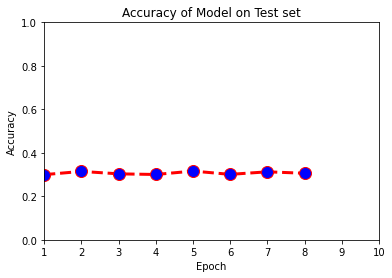

Average Accuracy =  0.3066806331471136


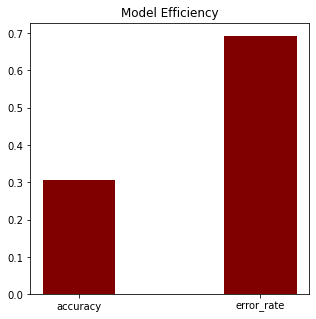

In [52]:
generate_report(accuracy_result)